# Table of contents
## Business Problem
### Data Loading and Preparation
### Data Exploration
### Data Analysis
### Summary


## Overview
- What are the data form
- what do the data describe
- Goals/Needs of the business
- summary

### Business Problem
- Recommend Movie for Facebook

#### List of questions to answer
1. What are the top 20 most watched genres(single genre)
2. Which genre has been watched the most in the recent years?
3. What particular genre has more gross income?
4. What is the recent trend in movie
5. What is the trend in production cost vs return?

Criteria:
- Budget limit :  >$50 mil
- Release time of year

## Data Loading and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Read csv files
df_imdb_name = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.name.basics.csv.gz')
df_imdb_aka = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.akas.csv.gz')
df_imdb_basic = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.basics.csv.gz')
df_imdb_crew = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.crew.csv.gz')
df_imdb_principal = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.principals.csv.gz')
df_imdb_ratings = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.ratings.csv.gz')

### Explore IMDB Datasets

In [3]:
# display(df_imdb_name.head(3))
# display(df_imdb_aka.head(3))
# display(df_imdb_basic.head(3))
# display(df_imdb_crew.head(3))
# display(df_imdb_principal.head(3))
# display(df_imdb_ratings.head(3))

In [416]:
# We will only use two IMDB datasets for our analysis

# Merge dataframes
df_imdb_merge = pd.merge(df_imdb_basic, df_imdb_ratings, on='tconst')

df_imdb_merge['title'] = df_imdb_merge['original_title']  # rename title
df_imdb_merge['year'] = df_imdb_merge['start_year']       # rename year
df_imdb_merge['genre'] = df_imdb_merge['genres']          # rename genre

df_imdb_merge.drop(columns = ['tconst', 'primary_title', 'original_title', 'start_year', 'genres'], inplace=True)

# Check to see how many rows lost in the process
print('No. of observations for imdb_basic:', df_imdb_basic.shape)
print('No. of observations for imdb_ratings:', df_imdb_ratings.shape)
print('No. of observations for imdb_crew:', df_imdb_crew.shape)
print('No. of observations for after merging imdb_basic and ratings:', df_imdb_merge.shape)

# df_imdb_merge = pd.merge(df_imdb_merge, df_imdb_crew, on='tconst')
# print('No. of observations for after mering imdb_basic, ratings and crew merged:', df_imdb_merge.shape)

No. of observations for imdb_basic: (146144, 6)
No. of observations for imdb_ratings: (73856, 3)
No. of observations for imdb_crew: (146144, 3)
No. of observations for after merging imdb_basic and ratings: (73856, 6)


In [5]:
# Lets replace the missing values. Although the  
# df_imdb_merge.fillna(value=0, inplace=True)
df_imdb_merge.head()

,runtime_minutes,averagerating,numvotes,title,year,genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama"
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama"
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama"
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"


In [417]:
df_imdb_merge['genre'] = df_imdb_merge['genre'].str.strip()

In [418]:
# Remove some non-movie category:
# AFI and BFI's definitions call any film longer than 40 minutes a feature.
# We will also get rid of movies that have rating below 5

df_imdb_merge_filter = df_imdb_merge[(df_imdb_merge['runtime_minutes'] >= 40)]
                                     #(df_imdb_merge['averagerating'] > 5)]



# Remove some non-movie category
df_imdb_merge_filter = df_imdb_merge[(df_imdb_merge['genre'] !='Documentary') & 
                                     (df_imdb_merge['genre'] !='Biography') & 
                                     (df_imdb_merge['genre'] !='History') &
                                     (df_imdb_merge['genre'] !='Music') &
                                     (df_imdb_merge['genre'] !='Reality-TV') & 
                                     (df_imdb_merge['genre'] != 'Sport') &
                                     (df_imdb_merge['genre'] != 'Short') &
                                     (df_imdb_merge['genre'] != 'News')
                                    ]
df_imdb_merge_filter.head()

,runtime_minutes,averagerating,numvotes,title,year,genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama"
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama"
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama"
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"


In [419]:
def make_genre_columns(df, genre_col):
    '''
    Split the individual genre type and put them into a separate column
    
    '''    
    # Get list of genres 
    list_of_all_genres = ','.join(str(x) for x in genre_col.unique())    
    unique_genres = {x for x in list_of_all_genres.split(',')}   # set comprehension
    print(unique_genres)
    
    # Get columns for each genre; values 0 or 1 if in that genre
    # make a copy of the dataframe
    df_copy = df.copy(deep=True)
    
    for genre in unique_genres:
        df_copy[genre] = df_copy.apply(lambda x: int(genre in str(x.genre)), axis=1) 
        
       
    return df_copy 

In [420]:
df_imdb_genres = make_genre_columns(df_imdb_merge, df_imdb_merge['genre'])

{'Adventure', 'War', 'History', 'Biography', 'nan', 'Sport', 'Game-Show', 'Drama', 'Reality-TV', 'Short', 'Crime', 'Fantasy', 'Comedy', 'News', 'Action', 'Documentary', 'Animation', 'Music', 'Musical', 'Horror', 'Sci-Fi', 'Mystery', 'Adult', 'Romance', 'Thriller', 'Western', 'Family'}


In [421]:
genres_to_discard = ['Music', 'Sport', 'History', 'Game-Show', 'Musical', 'News', 'Adult',
                     'Short', 'Biography', 'nan', 'Documentary', 'Reality-TV']
df_imdb_genres.drop(columns= genres_to_discard, inplace=True)

In [422]:
df_imdb_genres.head()

,runtime_minutes,averagerating,numvotes,title,year,genre,Adventure,War,Drama,Crime,...,Comedy,Action,Animation,Horror,Sci-Fi,Mystery,Romance,Thriller,Western,Family
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama",0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama",0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
# let calculate the count of total movies by genre each year
df_imdb_genres_count = df_imdb_genres.groupby('year').sum()
df_imdb_genres_count.drop(columns=['runtime_minutes', 'averagerating', 'numvotes'], inplace=True)
df_imdb_genres_count_T = df_imdb_genres_count.transpose()

In [369]:
df_imdb_genres_count_T.head(3)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Adventure,313,371,371,464,454,462,467,435,373,107
War,90,99,82,71,108,103,95,99,81,25
Drama,2902,3096,3175,3497,3529,3629,3523,3483,3054,900


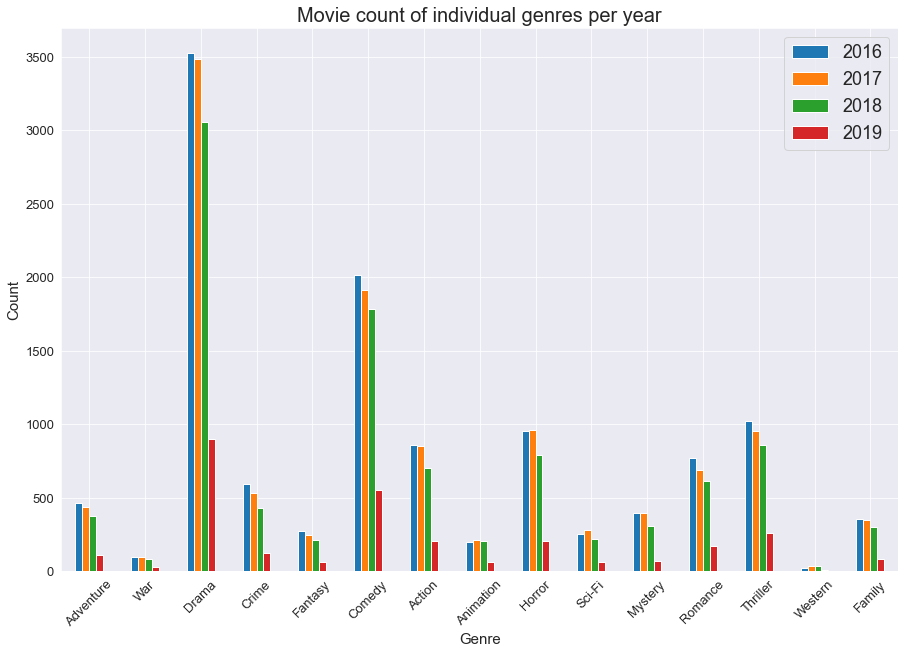

In [201]:
df_imdb_genres_count_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Movie count of individual genres per year", fontsize = 20)
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Movie_count_by_genres.png')

In [15]:
df_imdb_genres.head(3)

,runtime_minutes,averagerating,numvotes,title,year,genre,Adventure,War,Drama,Crime,...,Comedy,Action,Animation,Horror,Sci-Fi,Mystery,Romance,Thriller,Western,Family
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama",0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
genre_list = ['Drama', 'Animation', 'Thriller', 'Action', 'Western', 'Mystery', 'Horror',
                   'Crime', 'Comedy', 'Sci-Fi', 'War', 'Fantasy', 'Adventure', 'Romance', 'Family']

In [17]:
def fill_genre(df, genre_list, col_feature, columns_to_drop ):
    '''
    Fill the genre columns with values from desired feature or column
    col = desired feature
    '''
    for genre in list(genre_list):
        df[genre] = df[genre] * col_feature
    return df.drop(columns=columns_to_drop)

In [18]:
columns_to_drop = ['runtime_minutes', 'averagerating', 'numvotes', 'title', 'genre']
df_imdb_fill_ratings = fill_genre(df_imdb_genres, genre_list, df_imdb_genres['averagerating'], columns_to_drop)
df_imdb_fill_numvote  = fill_genre(df_imdb_genres, genre_list, df_imdb_genres['numvotes'], columns_to_drop)
df_imdb_fill_runtime  = fill_genre(df_imdb_genres, genre_list, df_imdb_genres['runtime_minutes'], columns_to_drop)

In [19]:
# df_imdb_fill_ratings_average.head()

In [20]:
# let calculate some statistics and group by year 
df_imdb_fill_ratings_average = df_imdb_fill_ratings.groupby('year').mean()
df_imdb_fill_ratings_average_T = df_imdb_fill_ratings_average.transpose()

In [159]:
df_imdb_fill_ratings_average_T.head(3)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Adventure,0.285836,0.310597,0.304753,0.359199,0.339864,0.332093,0.330478,0.305199,0.305169,0.321193
War,0.091357,0.086994,0.069336,0.055282,0.086859,0.077714,0.072790,0.077436,0.069187,0.074083
Drama,2.682921,2.648356,2.636628,2.797897,2.705591,2.688557,2.580759,2.585286,2.659806,2.825872


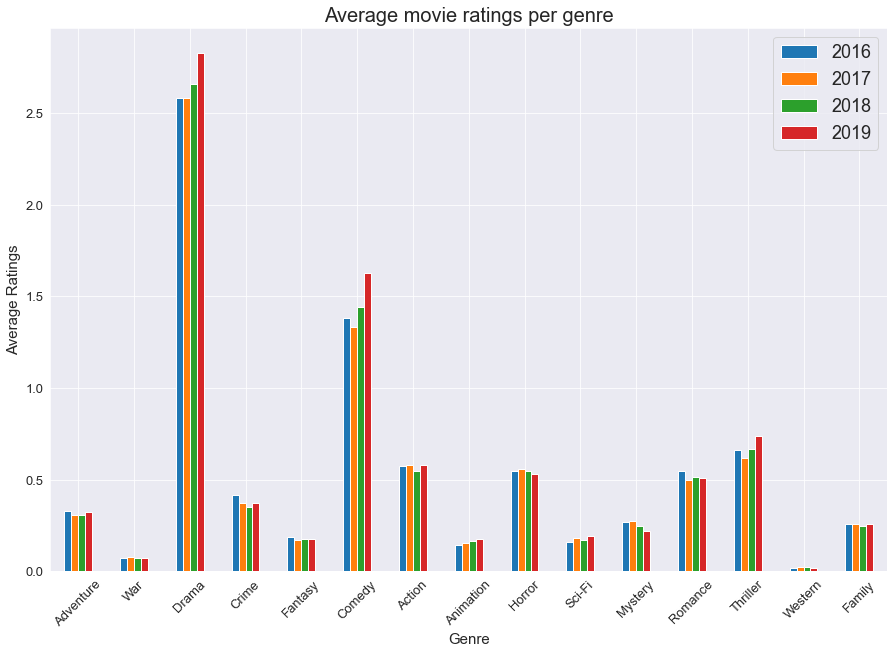

In [202]:
df_imdb_fill_ratings_average_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average movie ratings per genre", fontsize = 20)
plt.ylabel("Average Ratings", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Movie_ratings_by_genresin_in_last_4years.png')

In [22]:
# let calculate some statistics and group by year 
df_imdb_fill_numvote_average = df_imdb_fill_numvote.groupby('year').mean()
df_imdb_fill_numvote_average_T = df_imdb_fill_numvote_average.transpose()

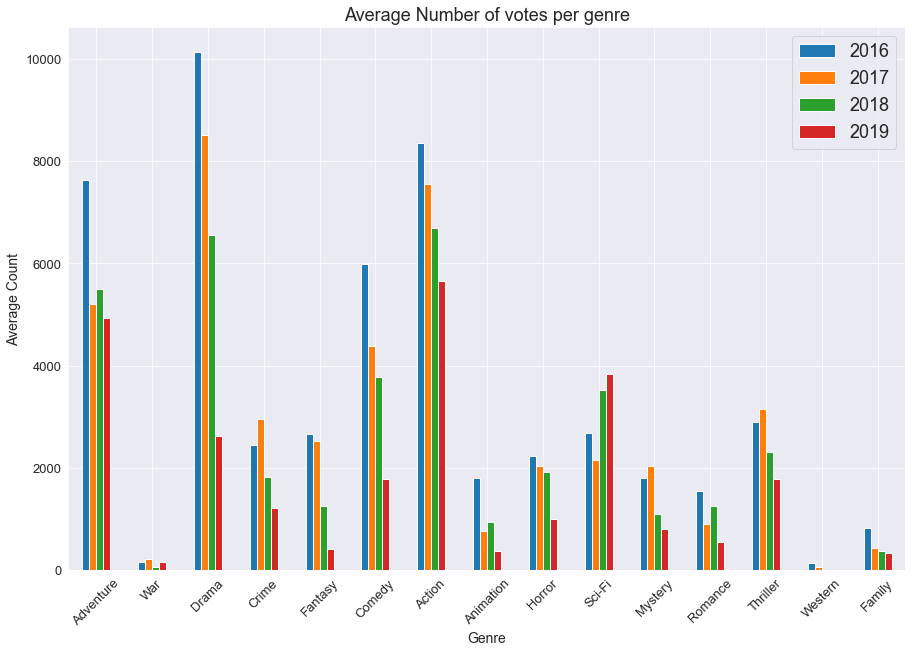

In [23]:
df_imdb_fill_numvote_average_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Number of votes per genre", fontsize = 18)
plt.ylabel("Average Count", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [24]:
# let calculate some statistics and group by year 
df_imdb_fill_runtime_average = df_imdb_fill_runtime.groupby('year').mean()
df_imdb_fill_runtime_average_T = df_imdb_fill_runtime_average.transpose()

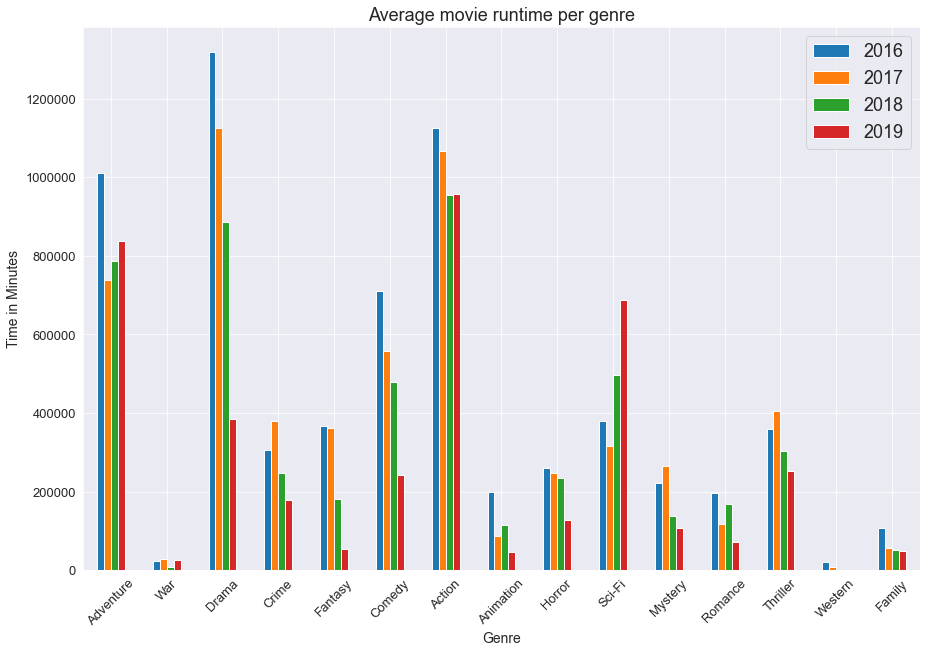

In [25]:
df_imdb_fill_runtime_average_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average movie runtime per genre", fontsize = 18)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Time in Minutes", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

### Load TMDB movies dataset

In [26]:
df_tmdb_raw = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/tmdb.movies.csv.gz')

In [27]:
# display(df_tmdb.info())
# display(df_tmdb.head())

We can see some genre id represented by some numbers. We can actually find the exact genre if we go to the tmdb genre website [here](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee)

Below is a dictionary of 'Movie' genres pertaining the number represantative

In [28]:
temp = {'Action': 28,
             'Adventure': 12,
             'Animation': 16,
             'Comedy': 35,
             'Crime': 80,
             'Documentary': 99,
             'Drama': 18,
             'Family': 10751,
             'Fantasy': 14,
             'History':36,
             'Horror': 27,
             'Music': 10402,
             'Mystery': 9648,
             'Romance': 10749,
             'Science Fiction': 878,
             'TV Movie': 10770,
             'Thriller': 53,
             'War': 1075,
             'Western': 37}

# Switch key-value pairs
tmdb_genre = {}
for k,v in temp.items():
    tmdb_genre[v] = k

In [29]:
def str_replace(input_str, key_dict=tmdb_genre, unknown_genre_str="UNK"):
    '''
    Replace genre id in integer format by text.
    Strip and split non-alphabetic characters and unpack into a list of genres.
    
    '''
    final_str = ""
    # Remove the first and last characters []
    final_str = input_str[1:-1]
    # Split the string to get list of numbers
    final_str = final_str.strip().split(',')
    # Assuming all strings are integers
    #TODO: Find when int() cast doesn't work
    try:
        final_str = [int(x) for x in final_str]
        # Replace numbers with words
        final_str = [key_dict.get(k,unknown_genre_str) for k in final_str]
        # Make one big string to return
    except:
        final_str = ""
    return ','.join(final_str)

In [30]:
df_tmdb = df_tmdb_raw.copy(deep=True)
df_tmdb['genre'] = df_tmdb['genre_ids'].apply(str_replace)


# we will extract 'year' and save it in a column.
df_tmdb['year'] = pd.DatetimeIndex(df_tmdb['release_date']).year

df_tmdb.drop(columns= ['Unnamed: 0','genre_ids', 'id', 'original_language', 'original_title'], inplace=True)
df_tmdb.head()

,popularity,release_date,title,vote_average,vote_count,genre,year
0,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure,Fantasy,Family",2010
1,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Fantasy,Adventure,Animation,Family",2010
2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Adventure,Action,Science Fiction",2010
3,28.005,1995-11-22,Toy Story,7.9,10174,"Animation,Comedy,Family",1995
4,27.920,2010-07-16,Inception,8.3,22186,"Action,Science Fiction,Adventure",2010


#### Q1. Which movie has the highest/lowest average votes/vote count?

In [31]:
def find_minmax(df,x):
    '''
    Return indices of a minimum or maximum of given features
    Return associated dataframes
    " This function was taken from a kaggle project"
    '''
    # Given the attribute, find min and max
    index_min = df[x].idxmin()
    index_max = df[x].idxmax()
    
    max = pd.DataFrame(df.loc[index_max, :])
    min = pd.DataFrame(df.loc[index_min, :])
    
    print("Movie with highest " + x + ":", df[x][index_max])
    print("Movie with lowest " + x + ":", df[x][index_min])
    
    return pd.concat([min, max], axis=1)    

In [32]:
find_minmax(df_tmdb, 'vote_average')

Movie with highest vote_average: 10.0
Movie with lowest vote_average: 0.0


,2467,770
popularity,0.6,2.288
release_date,2010-01-01,2010-01-01
title,Edie: Girl on Fire,Full Love
vote_average,0,10
vote_count,1,1
genre,,"Action,Crime,Drama,Thriller"
year,2010,2010


In [33]:
find_minmax(df_tmdb, 'vote_count')

Movie with highest vote_count: 22186
Movie with lowest vote_count: 1


,770,4
popularity,2.288,27.92
release_date,2010-01-01,2010-07-16
title,Full Love,Inception
vote_average,10,8.3
vote_count,1,22186
genre,"Action,Crime,Drama,Thriller","Action,Science Fiction,Adventure"
year,2010,2010


#### Most popular movie

In [34]:
data = pd.DataFrame(df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10))
data.reset_index(inplace=True)

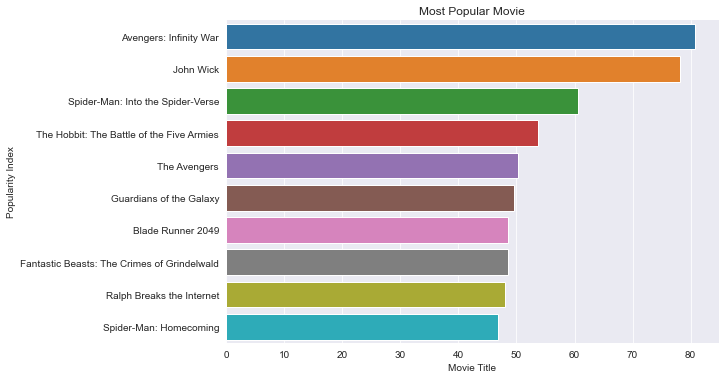

In [35]:
# df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='purple', figsize=(12,8))

data = pd.DataFrame(df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10))
data.reset_index(inplace=True)
ax = sns.catplot(data = data, y='title', x='popularity', orient='h', kind='bar', aspect=2)
plt.xlabel('Movie Title')
plt.ylabel('Popularity Index')
plt.xticks(rotation= None)
plt.title('Most Popular Movie');

#### Add genre columns

In [49]:
df_tmdb_genre = make_genre_columns(df_tmdb, df_tmdb['genre'])

{'Adventure', 'Science Fiction', '', 'History', 'Crime', 'Fantasy', 'Comedy', 'Action', 'Documentary', 'Animation', 'Music', 'UNK', 'TV Movie', 'Horror', 'Mystery', 'Romance', 'Family', 'Thriller', 'Western', 'Drama'}


In [40]:
df_tmdb_genre.columns

Index(['popularity', 'release_date', 'title', 'vote_average', 'vote_count',
       'genre', 'year', 'Adventure', 'Science Fiction', '', 'History', 'Crime',
       'Fantasy', 'Comedy', 'Action', 'Documentary', 'Animation', 'Music',
       'UNK', 'TV Movie', 'Horror', 'Mystery', 'Romance', 'Family', 'Thriller',
       'Western', 'Drama'],
      dtype='object')

In [50]:
# War genre is not detected, so we will remove that
tmdb_genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
                   'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 
                   'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'Western']

#### Fill genre columns

In [51]:
temp_columns_to_drop = ['popularity', 'release_date', 'title', 'vote_average', 'vote_count', 'genre', '', 'UNK']
df_tmdb_popularity = fill_genre(df_tmdb_genre, tmdb_genre_list, df_tmdb_genre['popularity'], temp_columns_to_drop)
df_tmdb_avgvote = fill_genre(df_tmdb_genre, tmdb_genre_list, df_tmdb_genre['vote_average'], temp_columns_to_drop)
df_tmdb_votecount = fill_genre(df_tmdb_genre, tmdb_genre_list, df_tmdb_genre['vote_count'], temp_columns_to_drop)

In [52]:
df_tmdb_popularity_avg = df_tmdb_popularity.groupby('year').mean()
df_tmdb_popularity_avg_T = df_tmdb_popularity_avg.transpose()

df_tmdb_popularity_std = df_tmdb_popularity.groupby('year').std()
df_tmdb_popularity_std_T = df_tmdb_popularity_std.transpose()

In [53]:
df_tmdb_vote_avg = df_tmdb_avgvote.groupby('year').mean()
df_tmdb_vote_avg_T = df_tmdb_avgvote.transpose()

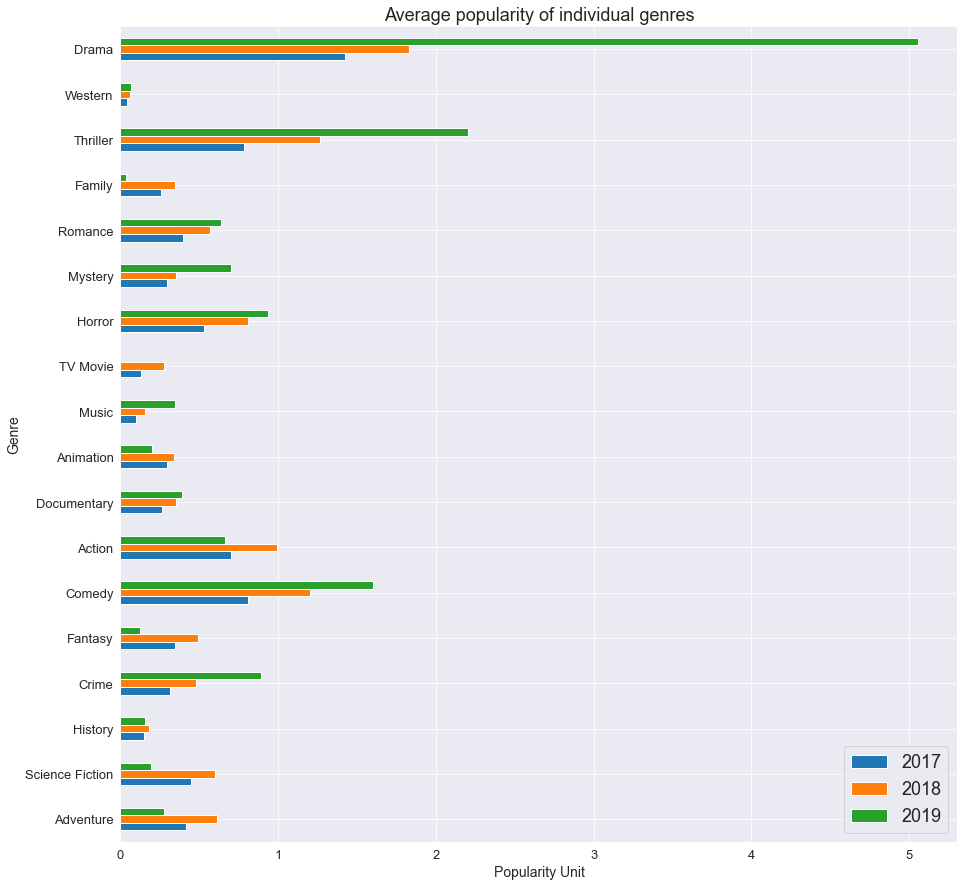

In [54]:
# Plot tmdb popularity
df_tmdb_popularity_avg_T.iloc[:, 62:65].plot(kind='barh',figsize = (15,15),fontsize=13)
plt.title("Average popularity of individual genres", fontsize = 18)
plt.xlabel("Popularity Unit", fontsize = 14)
plt.ylabel("Genre", fontsize = 14)
plt.legend(prop={'size':18});

Dram, thriller and comedy are more popular genre in the latest years. We can also see gradual rise of genre like horror, romance, crime. Unlike the adventure, action and science fiction has opposite trend for the last year. 

Althought the average popularity is high for the drama movie, but is also highly correlable to the total movie counts per genre derived from imdb dataset. 

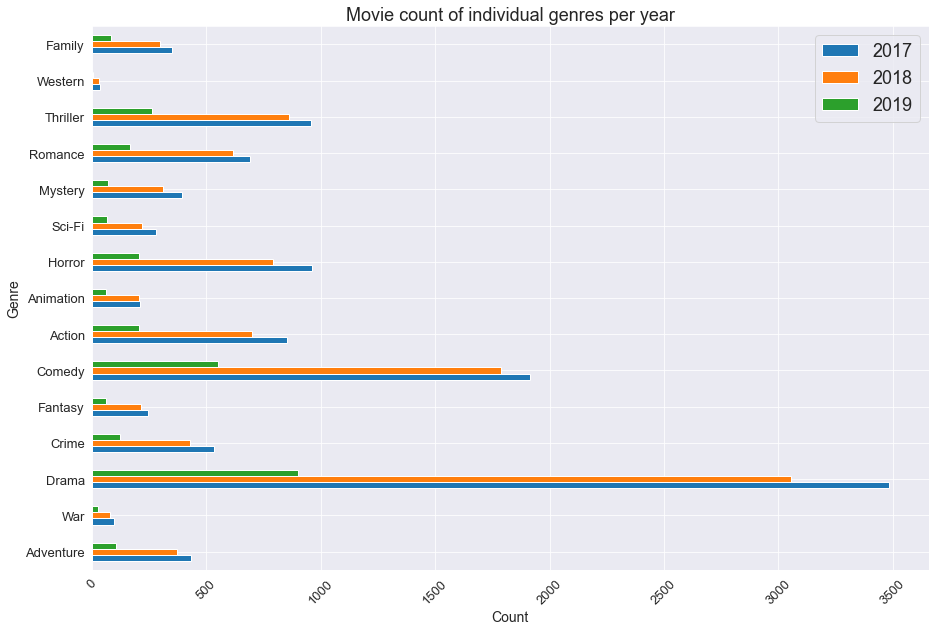

In [55]:
df_imdb_genres_count_T.iloc[:, 7:].plot(kind='barh',figsize = (15,10),fontsize=13)
plt.title("Movie count of individual genres per year", fontsize = 18)
plt.ylabel("Genre", fontsize = 14)
plt.xlabel("Count", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

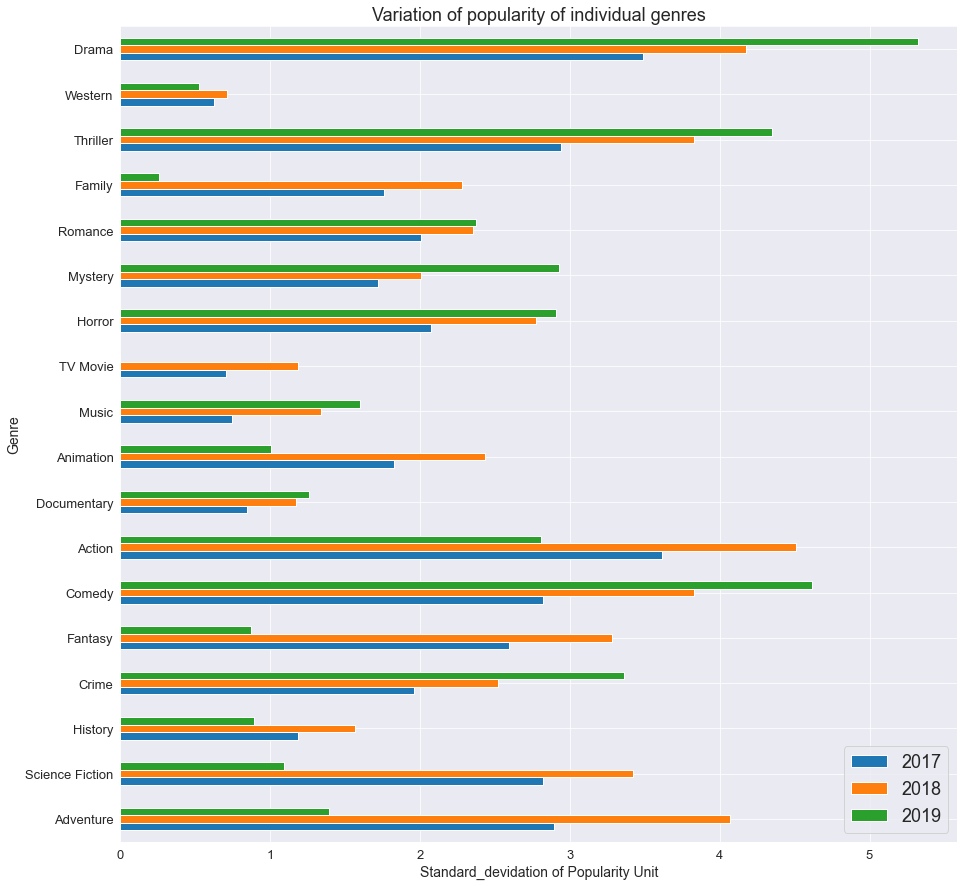

In [56]:
df_tmdb_popularity_std_T.iloc[:, 62:65].plot(kind='barh',figsize = (15,15),fontsize=13)
plt.title("Variation of popularity of individual genres", fontsize = 18)
plt.xlabel("Standard_devidation of Popularity Unit", fontsize = 14)
plt.ylabel("Genre", fontsize = 14)
plt.legend(prop={'size':18});

### Load TN Budget Dataset

In [58]:
df_tn = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/tn.movie_budgets.csv.gz')

In [59]:
display(df_tn.info())
display(df_tn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [60]:
# Simple function to convert some currency values into numeric values

def conv_numeric(x):
    '''
    Convert string object to numeric type by removing '$' and delimiters
    Leave the numeric value as it is. 
    '''
    if isinstance(x, str):
        return float(x.replace(',', '').replace('$', ''))
    return float(x)

# Note: float function at the begining as it is applying on individual string

In [61]:
df_tn['production_budget'] = df_tn['production_budget'].apply(conv_numeric)
df_tn['domestic_gross'] = df_tn['domestic_gross'].apply(conv_numeric)
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].apply(conv_numeric)

In [62]:
# Drop rows missing budget information 
df_tn = df_tn.dropna(axis = 0,
                     subset = ['production_budget', 'domestic_gross', 'worldwide_gross'])

# drop rows with missing domestic gross
df_tn = df_tn[(df_tn['domestic_gross']) != 0]

# we will extract 'year' and save it in a column
# later we will use this in conjunction with movie title to merge with imdb dataset

df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])
df_tn['year'] = pd.DatetimeIndex(df_tn['release_date']).year
df_tn['title'] = df_tn['movie']

df_tn.drop(columns=['movie'], inplace=True)
df_tn.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,title
0,1,2009-12-18,425000000.0,760507625.0,2.776345e+09,2009,Avatar
1,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides
2,3,2019-06-07,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix
3,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron
4,5,2017-12-15,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi


In [63]:
# Perform some arithmatic 
df_tn['foreign_gross'] = df_tn['worldwide_gross'] - df_tn['domestic_gross']
df_tn['worldwide_profit'] = df_tn['worldwide_gross'] - df_tn['production_budget']
df_tn['domestic_profit'] = df_tn['domestic_gross'] - df_tn['production_budget']

# Calculate production to revenue ratio
df_tn['domestic_cost_profit_ratio'] = df_tn['production_budget'] / df_tn['domestic_profit'] 
df_tn['worldwide_cost_profit_ratio'] = df_tn['production_budget'] / df_tn['worldwide_profit'] 

# Normalization
df_tn['domestic_gross_n'] = df_tn['domestic_gross'].apply(
                            lambda x: (x - df_tn['domestic_gross'].mean())/df_tn['domestic_gross'].std())

df_tn['worldwide_gross_n'] = df_tn['worldwide_gross'].apply(
                            lambda x: (x - df_tn['worldwide_gross'].mean())/df_tn['worldwide_gross'].std())


df_tn.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,title,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,domestic_gross_n,worldwide_gross_n
0,1,2009-12-18,425000000.0,760507625.0,2.776345e+09,2009,Avatar,2.015838e+09,2.351345e+09,335507625.0,1.266737,0.180748,10.160535,14.772221
1,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,2.771210,5.216920
2,3,2019-06-07,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix,1.070000e+08,-2.002376e+08,-307237650.0,-1.139183,-1.747923,-0.049720,0.270540
3,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,5.871535,7.189893
4,5,2017-12-15,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi,6.965404e+08,9.997217e+08,303181382.0,1.045579,0.317088,8.164330,6.713463


### Top 10 most expensive movies

C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


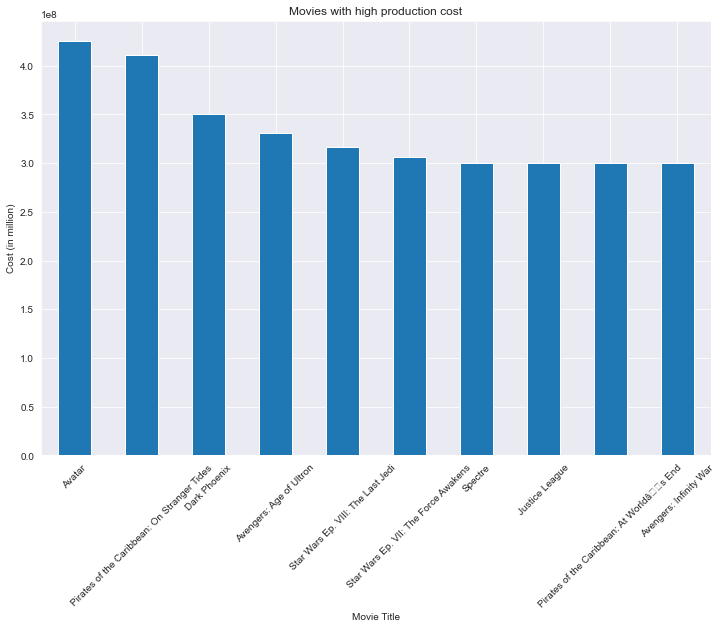

In [64]:
df_tn.groupby('title')['production_budget'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Cost (in million)')
plt.xticks(rotation= 45)
plt.title('Movies with high production cost');

### Top 10 movies with highest domestic revenue

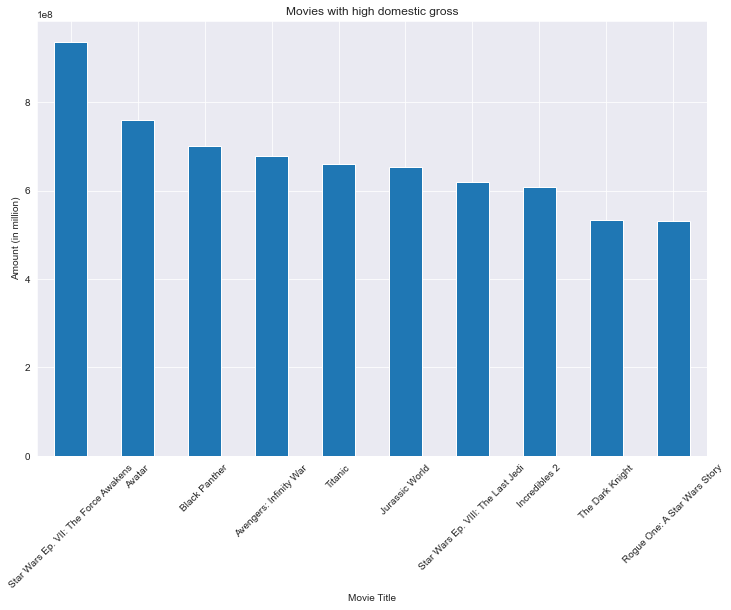

In [65]:
df_tn.groupby('title')['domestic_gross'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Amount (in million)')
plt.xticks(rotation= 45)
plt.title('Movies with high domestic gross');

### Top 10 movies with highest worldwide revenue

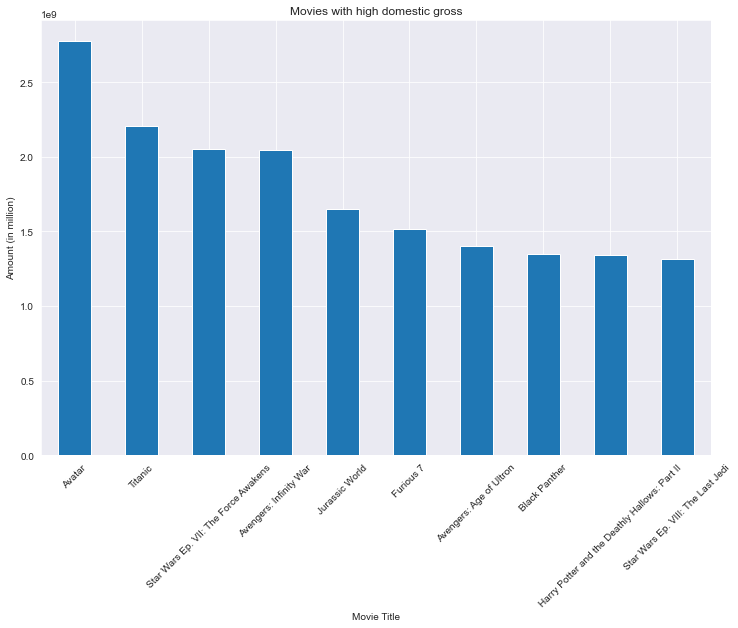

In [205]:
df_tn.groupby('title')['worldwide_gross'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Amount (in million)')
plt.xticks(rotation= 45)
plt.title('Movies with high domestic gross');

### Top 10 moves with the highest cost profit ratio

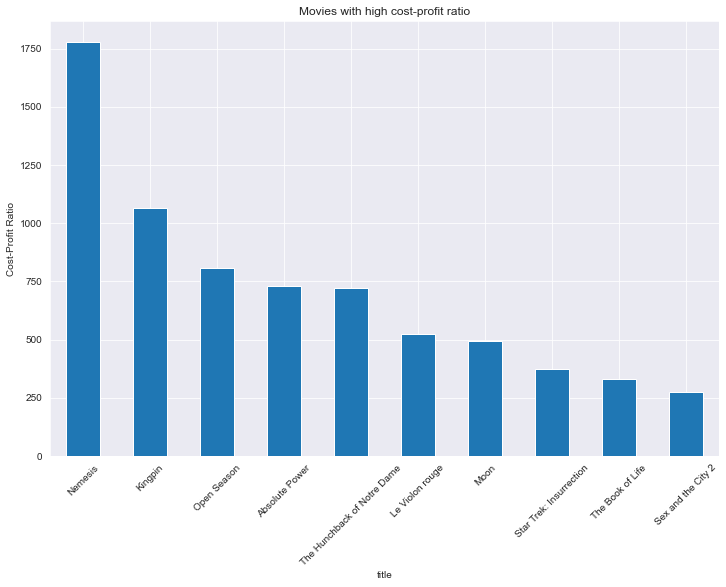

In [53]:
df_tn.groupby('title')['domestic_cost_profit_ratio'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
# plt.xlabel('Movie Title')
plt.ylabel('Cost-Profit Ratio')
plt.xticks(rotation= 45)
plt.title('Movies with high cost-profit ratio');

####  Lets remove some low budget movies from the equation


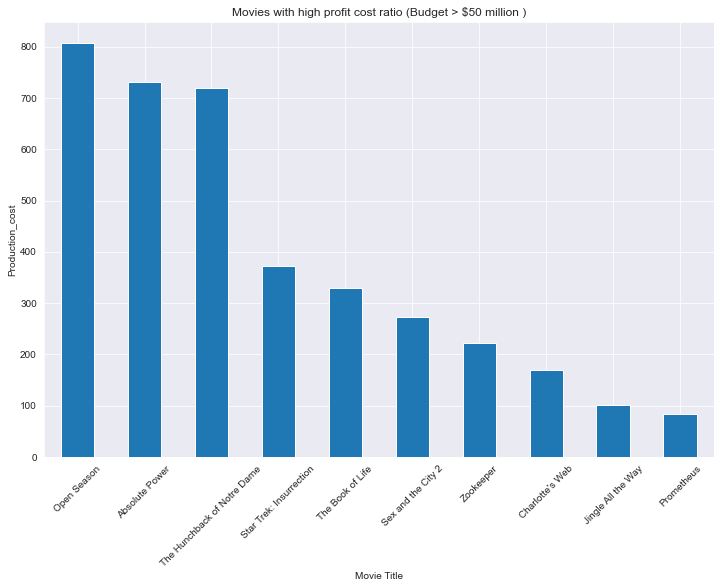

In [66]:
df_tn_hi_budget = df_tn[(df_tn['production_budget'] >= 50000000)]

df_tn_hi_budget.groupby('title')['domestic_cost_profit_ratio'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Production_cost')
plt.xticks(rotation= 45)
plt.title('Movies with high profit cost ratio (Budget > $50 million )');

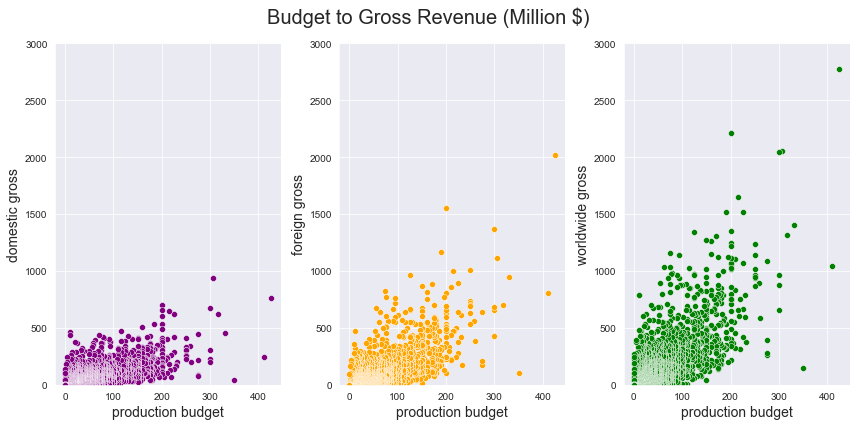

<Figure size 432x288 with 0 Axes>

In [204]:
# Compare Gross Revenues
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,6))
fig.set_tight_layout(True)
sns.scatterplot(x=df_tn['production_budget']/1000000, y=df_tn['domestic_gross']/1000000, color='purple', ax=axes[0])
sns.scatterplot(x=df_tn['production_budget']/1000000, y=df_tn['worldwide_gross']/1000000, color='green', ax=axes[2])
sns.scatterplot(x=df_tn['production_budget']/1000000, y=df_tn['foreign_gross']/1000000, color='orange', ax=axes[1])

fig.suptitle("Budget to Gross Revenue (Million $)", fontsize=20)
axes[0].set_ylabel("domestic gross", fontsize=14)
axes[1].set_ylabel("foreign gross", fontsize=14)
axes[2].set_ylabel("worldwide gross", fontsize=14)

axes[0].set_xlabel("production budget", fontsize=14)
axes[1].set_xlabel("production budget", fontsize=14)
axes[2].set_xlabel("production budget", fontsize=14)

axes[0].set_ylim([0,3000])
axes[1].set_ylim([0,3000])
axes[2].set_ylim([0,3000])

plt.show();
plt.savefig('Budget_to_gross_revenue.png')

Strong correlation of budget with worldwide gross!

### Load BOM Datasets

In [68]:
df_bom = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/bom.movie_gross.csv.gz')

In [69]:
df_bom.info()
display(df_bom.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


The gross revenue data are already in the TN Budget dataset, we will simply merge BOM to the TN dataset and keep the studio information only


### Load Rotten Tomatoes Dataset

In [70]:
# Read .tsv files
df_rt_movies = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/rt.movie_info.tsv.gz', delimiter = '\t')

# following data is in different latin1  codec latin
df_rt_reviews = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/rt.reviews.tsv.gz', delimiter = '\t', encoding='latin1')

In [71]:
display(df_rt_movies.head(3))

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN


In [72]:
df_rt_movies.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [73]:
df_rt_reviews.head(3)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"


In [74]:
df_rt_reviews.isna().sum()

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

Rotten Tomatoes dataset has lot of missing data and lacks suitable key to merge with other dataframe. For this study, we will ignore the Rotten Tomatoes datasets.

## Combine datasets from different source into a single dataframe

In [423]:
# We will try clean up as much possible the movie title for better match

def string_clean(x):
    '''
    Simple string manipulation to replace,remove inconsistencies in naming
    '''
    x = x.lower()
    x = x.replace('&', 'and')
    x = x.replace('#', '')
    x = x.replace('$', '')
    x = x.replace('*', '')
    x = x.replace('-', '')
    x = x.replace(',', '')
    x = x.replace('_', '')
    x = x.replace(':', '')
    x = x.replace(';', '')
    x = x.replace('[', '')
    x = x.replace(']', '')
    x = x.replace('(', '')
    x = x.replace(')', '')
    x = x.replace('+', '')
    x = x.replace('.', '')
    x = x.replace('/', '')
    x = x.strip()
    return x

In [424]:
df_tn['title_edit'] = df_tn['title'].apply(string_clean)
df_bom['title_edit'] = df_bom['title'].apply(string_clean)
df_imdb_merge['title_edit'] = df_imdb_merge['title'].apply(string_clean)
df_tmdb['title_edit'] = df_tmdb['title'].apply(string_clean)

In [425]:
# Merge dataset
df_merge1 = pd.merge(df_tn, df_imdb_merge, on= ['title_edit', 'year'])
df_merge2 = pd.merge(df_merge1, df_tmdb, on= ['title_edit', 'year'])
df_merge3 = pd.merge(df_merge2, df_bom, on= ['title_edit', 'year'])

df_merge = df_merge3.copy(deep=True)

print('No. of observations for TN budget dataset:', df_tn.shape[0])
print('No. of observations for IMDB dataset:', df_imdb_merge.shape[0])
print('No. of observations for BOM dataset:', df_bom.shape[0])
print('No. of observations for TMDB dataset:', df_tmdb.shape[0])

print('No. of observation after merge IMDB :', df_merge1.shape[0])
print('No. of observation after merge TMDB :', df_merge2.shape[0])
print('No. of observation after merge BOM :', df_merge3.shape[0])

df_merge.head()

No. of observations for TN budget dataset: 5234
No. of observations for IMDB dataset: 73856
No. of observations for BOM dataset: 3387
No. of observations for TMDB dataset: 26517
No. of observation after merge IMDB : 1389
No. of observation after merge BOM : 1109
No. of observation after merge TMDB : 1202


,id,release_date_x,production_budget,domestic_gross_x,worldwide_gross,year,title_x,foreign_gross_x,worldwide_profit,domestic_profit,...,title_x,studio,domestic_gross_y,foreign_gross_y,popularity,release_date_y,title_y,vote_average,vote_count,genre_y
0,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides,8.046000e+08,6.350639e+08,-169536125.0,...,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571,"Adventure,Action,Fantasy"
1,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron,9.440081e+08,1.072414e+09,128405868.0,...,Avengers: Age of Ultron,BV,459000000.0,946400000,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457,"Action,Adventure,Science Fiction"
2,7,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,Avengers: Infinity War,1.369319e+09,1.748134e+09,378815482.0,...,Avengers: Infinity War,BV,678800000.0,"1,369.5",80.773,2018-04-27,Avengers: Infinity War,8.3,13948,"Adventure,Action,Fantasy"
3,9,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,Justice League,4.269209e+08,3.559452e+08,-70975705.0,...,Justice League,WB,229000000.0,428900000,34.953,2017-11-17,Justice League,6.2,7510,"Action,Adventure,Fantasy,Science Fiction"
4,9,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,Justice League,4.269209e+08,3.559452e+08,-70975705.0,...,Justice League,WB,229000000.0,428900000,34.953,2017-11-17,Justice League,6.2,7510,"Action,Adventure,Fantasy,Science Fiction"


In [426]:
df_merge.columns

Index(['id', 'release_date_x', 'production_budget', 'domestic_gross_x',
       'worldwide_gross', 'year', 'title_x', 'foreign_gross_x',
       'worldwide_profit', 'domestic_profit', 'domestic_cost_profit_ratio',
       'worldwide_cost_profit_ratio', 'domestic_gross_n', 'worldwide_gross_n',
       'title_edit', 'runtime_minutes', 'averagerating', 'numvotes', 'title_y',
       'genre_x', 'title_x', 'studio', 'domestic_gross_y', 'foreign_gross_y',
       'popularity', 'release_date_y', 'title_y', 'vote_average', 'vote_count',
       'genre_y'],
      dtype='object')

In [427]:
df_merge.rename(columns = 
                {"release_date_x": "release_date",
                 "domestic_gross_x":"domestic_gross",
                 "foreign_gross_x": "foreign_gross",
                 "genre_x": "genre"},
                
                inplace = True)

In [428]:
df_merge.columns

Index(['id', 'release_date', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'year', 'title_x', 'foreign_gross',
       'worldwide_profit', 'domestic_profit', 'domestic_cost_profit_ratio',
       'worldwide_cost_profit_ratio', 'domestic_gross_n', 'worldwide_gross_n',
       'title_edit', 'runtime_minutes', 'averagerating', 'numvotes', 'title_y',
       'genre', 'title_x', 'studio', 'domestic_gross_y', 'foreign_gross_y',
       'popularity', 'release_date_y', 'title_y', 'vote_average', 'vote_count',
       'genre_y'],
      dtype='object')

In [429]:
final_columns_to_drop = ['id', 'title_x', 'title_y', 'domestic_gross_y', 'foreign_gross_y',
                         'release_date_y', 'title_y', 'genre_y']
df_merge.drop(columns = final_columns_to_drop, inplace=True)

In [521]:
df_merge.columns

Index(['release_date', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'year', 'foreign_gross', 'worldwide_profit',
       'domestic_profit', 'domestic_cost_profit_ratio',
       'worldwide_cost_profit_ratio', 'domestic_gross_n', 'worldwide_gross_n',
       'title_edit', 'runtime_minutes', 'averagerating', 'numvotes', 'genre',
       'studio', 'popularity', 'vote_average', 'vote_count', 'prim_genre',
       'second_genre', 'tertiary_genre'],
      dtype='object')

In [509]:
df_merge_genres = make_genre_columns(df_merge, df_merge['genre'])

{'Adventure', 'War', 'History', 'Biography', 'Sport', 'nan', 'Crime', 'Fantasy', 'Comedy', 'Action', 'Documentary', 'Animation', 'Music', 'Musical', 'Horror', 'Sci-Fi', 'Mystery', 'Romance', 'Family', 'Thriller', 'Western', 'Drama'}


In [510]:
df_merge_genres.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,Music,Musical,Horror,Sci-Fi,Mystery,Romance,Family,Thriller,Western,Drama
0,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,...,0,0,0,0,0,0,0,0,0,0
1,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,...,0,0,0,1,0,0,0,0,0,0
2,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,1.369319e+09,1.748134e+09,378815482.0,0.791942,0.171612,...,0,0,0,1,0,0,0,0,0,0
3,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,0,0,0,0,0,0,0,0,0,0
4,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,0,0,0,0,0,0,0,0,0,0


In [518]:
# let calculate the count of total movies by genre each year for combined datasets
df_merge_genres_grpby_year = df_merge_genres.groupby('year').sum()

groupby_cols_to_drop = ['production_budget', 'domestic_gross', 'worldwide_gross', 'foreign_gross', 
                      'worldwide_profit', 'domestic_profit', 'domestic_cost_profit_ratio', 
                      'worldwide_cost_profit_ratio', 'domestic_gross_n', 'worldwide_gross_n', 
                      'runtime_minutes', 'averagerating', 'numvotes', 'popularity', 'vote_average', 
                      'vote_count', 'War', 'Sport', 'Music', 'Musical', 'Western', 'Documentary', 
                      'History', 'Biography', 'nan']

df_merge_genres_grpby_year.drop(columns=groupby_cols_to_drop, inplace=True)
df_merge_genres_grpby_year_T = df_merge_genres_grpby_year.transpose()

In [519]:
df_merge_genres_grpby_year_T.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
Adventure,30,35,28,35,35,42,44,37,31
Crime,23,17,18,25,22,22,20,13,20
Fantasy,13,14,11,12,7,9,13,13,12
Comedy,63,56,56,45,38,56,53,50,29
Action,44,44,39,38,43,38,53,39,37


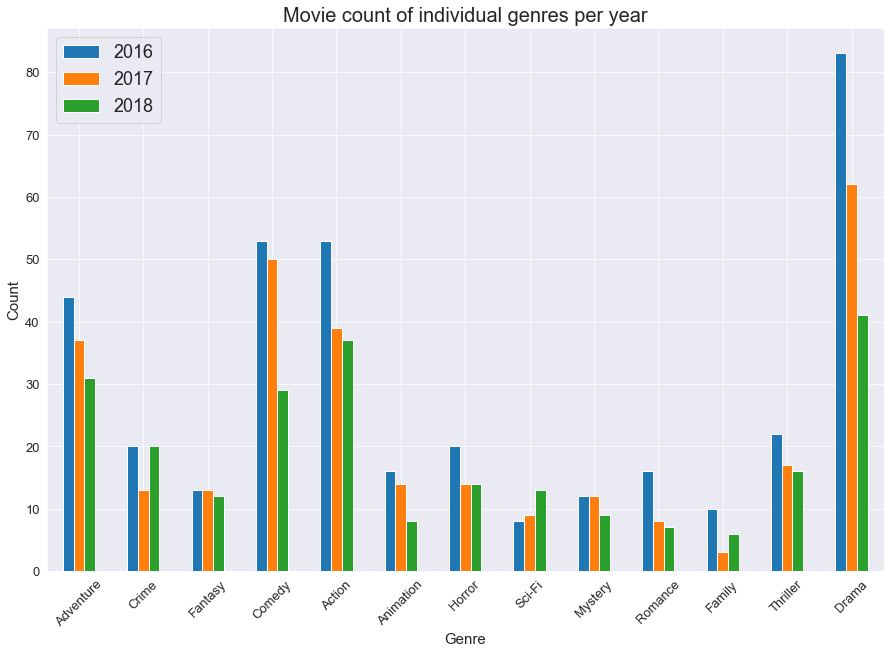

In [520]:
df_merge_genres_grpby_year_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Movie count of individual genres per year", fontsize = 20)
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
# plt.savefig('Movie_count_by_genres.png')

There is not data for 2019, perhaps lost during merging of the datasets.

### Re-assigning Genre Category

Earlier we filled up genre columns, if a particular genre is in the genre category. 
This time we will try assign two genre category: primary and secondary

In [431]:
# Add primary genre
df_merge['prim_genre'] = df_merge['genre'].str.split(',', expand = True)[0]
df_merge['second_genre'] = df_merge['genre'].str.split(',', expand = True)[1]
df_merge['tertiary_genre'] = df_merge['genre'].str.split(',', expand = True)[2]

In [432]:
df_merge['prim_genre'].isna().sum()

1

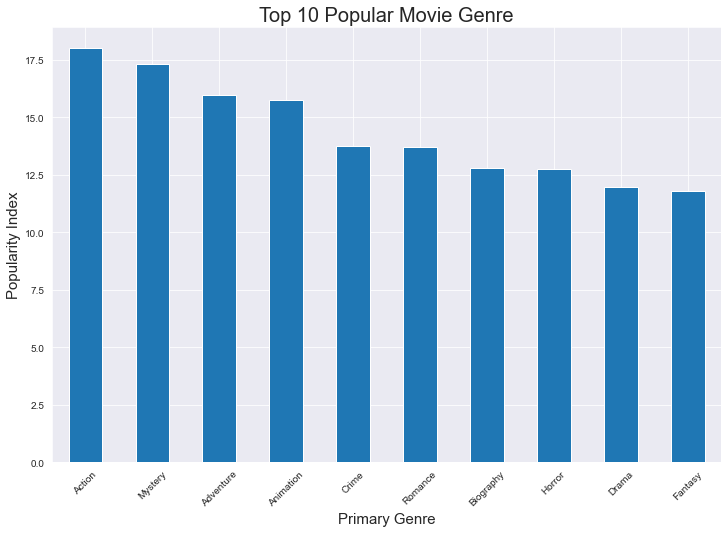

In [433]:
df_merge.groupby(['prim_genre'])['popularity'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Popularity Index', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 Popular Movie Genre', fontsize=20);
plt.savefig('Top10_popular_movie_genre.png')

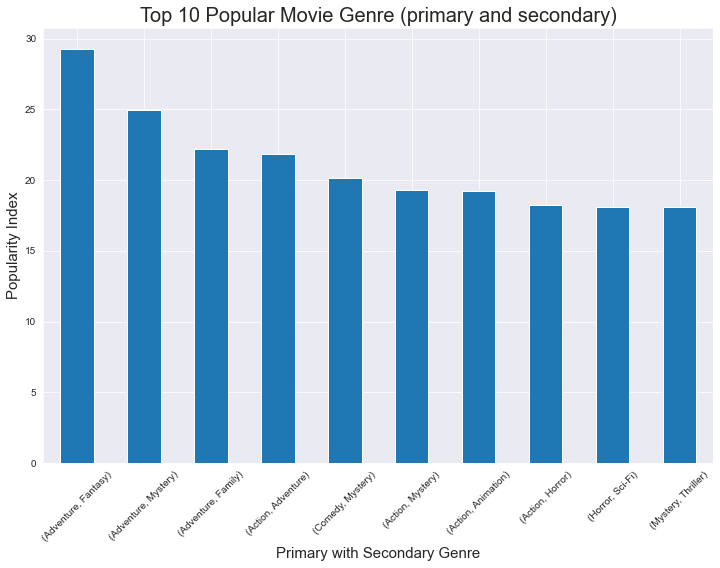

In [434]:
df_merge.groupby(['prim_genre', 'second_genre'])['popularity'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary with Secondary Genre', fontsize=15)
plt.ylabel('Popularity Index', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 Popular Movie Genre (primary and secondary)', fontsize=20);
plt.savefig('Top10_popular_movie_genre_primary_secondary.png')

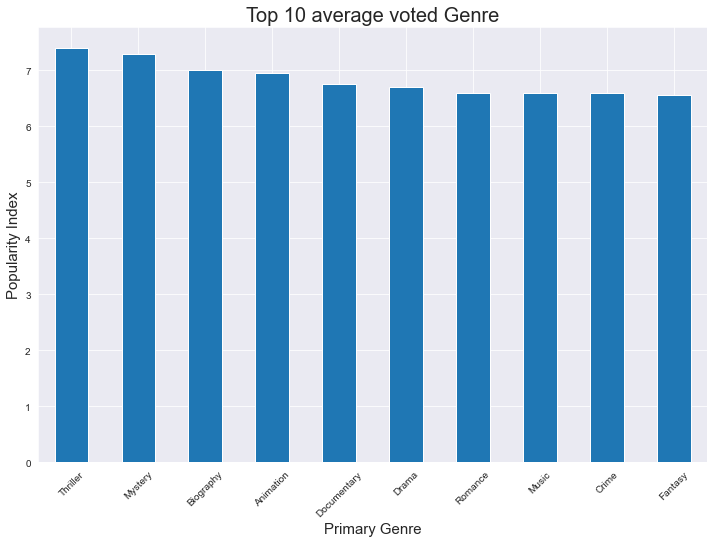

In [435]:
df_merge.groupby(['prim_genre'])['vote_average'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Popularity Index', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 average voted Genre', fontsize=20);
# plt.savefig('Top10_popular_movie_genre.png')

<AxesSubplot:xlabel='prim_genre'>

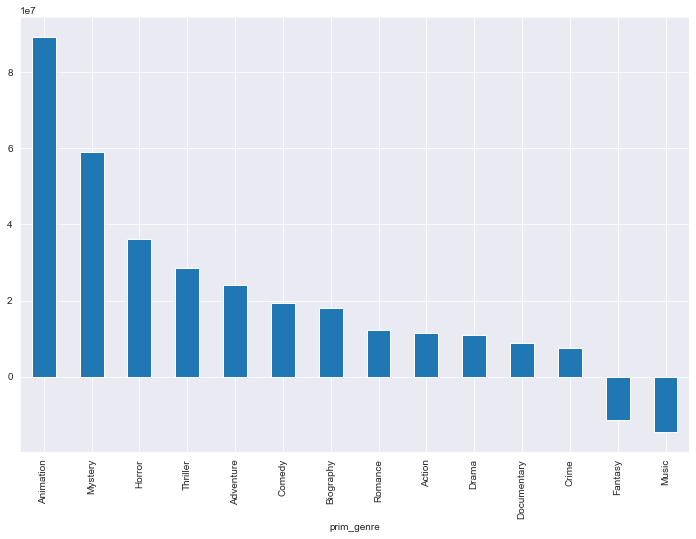

In [436]:
df_merge.groupby('prim_genre')['domestic_profit'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(12,8))


<AxesSubplot:xlabel='prim_genre'>

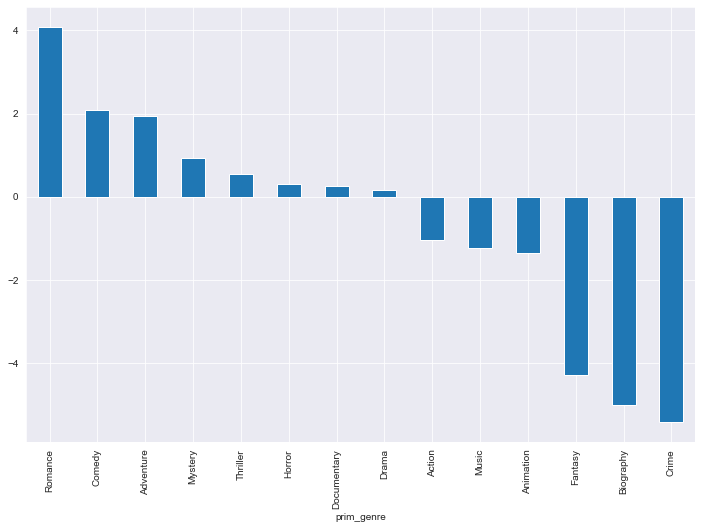

In [437]:
df_merge.groupby('prim_genre')['domestic_cost_profit_ratio'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(12,8))


In [447]:
df_merge.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count,prim_genre,second_genre,tertiary_genre
0,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,...,6.6,447624,"Action,Adventure,Fantasy",BV,30.579,6.4,8571,Action,Adventure,Fantasy
1,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,...,7.3,665594,"Action,Adventure,Sci-Fi",BV,44.383,7.3,13457,Action,Adventure,Sci-Fi
2,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,1.369319e+09,1.748134e+09,378815482.0,0.791942,0.171612,...,8.5,670926,"Action,Adventure,Sci-Fi",BV,80.773,8.3,13948,Action,Adventure,Sci-Fi
3,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy
4,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy


In [439]:
df_merge.loc[(df_merge.prim_genre=='Animation')]

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count,prim_genre,second_genre,tertiary_genre
231,2012-09-28,85000000.0,148313048.0,378505812.0,2012,230192764.0,293505812.0,63313048.0,1.342535,0.289602,...,7.1,204571,"Animation,Comedy,Family",Sony,15.318,6.9,5013,Animation,Comedy,Family
245,2015-09-25,80000000.0,169700110.0,469500298.0,2015,299800188.0,389500298.0,89700110.0,0.891861,0.205391,...,6.7,92905,"Animation,Comedy,Family",Sony,16.553,6.7,3184,Animation,Comedy,Family
263,2016-12-21,75000000.0,270329045.0,634454789.0,2016,364125744.0,559454789.0,195329045.0,0.383967,0.134059,...,7.1,115951,"Animation,Comedy,Family",Uni.,17.572,6.9,4303,Animation,Comedy,Family
264,2016-12-21,75000000.0,270329045.0,634454789.0,2016,364125744.0,559454789.0,195329045.0,0.383967,0.134059,...,7.1,115951,"Animation,Comedy,Family",Uni.,17.572,6.9,4303,Animation,Comedy,Family
291,2010-07-09,69000000.0,251513985.0,543464573.0,2010,291950588.0,474464573.0,182513985.0,0.378053,0.145427,...,7.7,464511,"Animation,Comedy,Family",Uni.,23.673,7.2,10057,Animation,Comedy,Family
498,2012-10-05,39000000.0,35287788.0,81150788.0,2012,45863000.0,42150788.0,-3712212.0,-10.505866,0.925250,...,7.0,89489,"Animation,Comedy,Family",BV,14.627,6.8,1685,Animation,Comedy,Family
1034,2015-12-30,8000000.0,3759286.0,5706168.0,2015,1946882.0,-2293832.0,-4240714.0,-1.886475,-3.487614,...,7.3,58010,"Animation,Comedy,Drama",Par.,10.285,7.1,927,Animation,Comedy,Drama
1035,2015-12-30,8000000.0,3759286.0,5706168.0,2015,1946882.0,-2293832.0,-4240714.0,-1.886475,-3.487614,...,7.3,58010,"Animation,Comedy,Drama",Par.,10.285,7.1,927,Animation,Comedy,Drama


In [448]:
# Create pivot table of genre vs year of attributes to be mapped
df_merge_pivot_avgrating = pd.pivot_table(df_merge, values='averagerating', index='prim_genre', columns='year', aggfunc='mean')
df_merge_pivot_avgrating.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
prim_genre,,,,,,,,,
Action,6.334091,6.309091,6.392308,6.528947,6.627907,6.457895,6.528302,6.612821,6.489189
Adventure,6.457143,6.272222,6.984615,6.583333,6.600000,6.420000,6.705263,6.300000,5.923077
Animation,7.700000,NaN,7.050000,NaN,NaN,7.100000,7.100000,NaN,NaN
Biography,7.128571,6.800000,7.066667,7.445455,6.883333,7.207143,7.252174,7.093750,6.761538
Comedy,5.994595,6.308571,6.255556,6.391667,6.245833,6.240741,6.233333,6.107143,6.384615


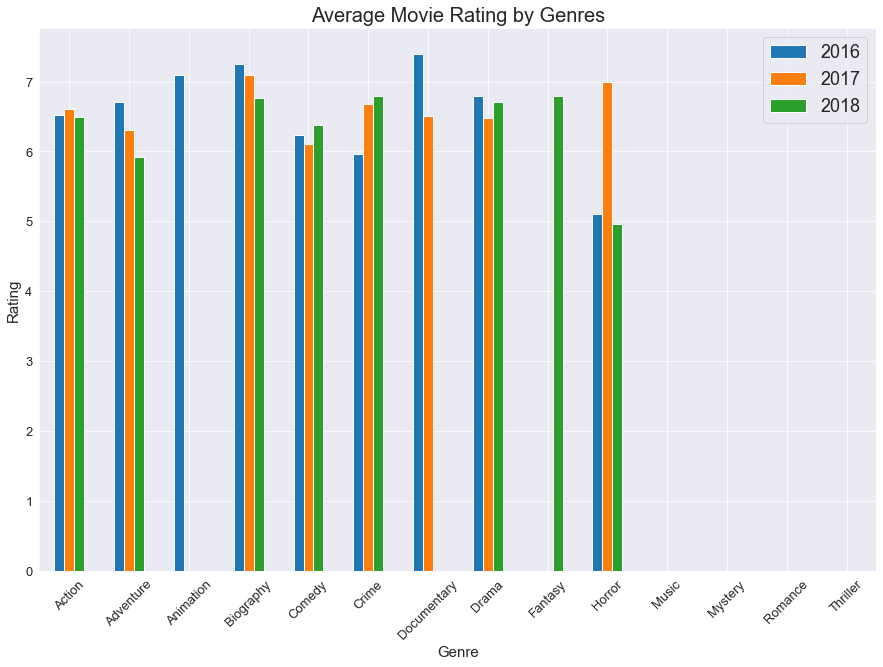

In [449]:
df_merge_pivot_avgrating.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Movie Rating by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Rating", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [452]:
df_merge.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count,prim_genre,second_genre,tertiary_genre
0,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,...,6.6,447624,"Action,Adventure,Fantasy",BV,30.579,6.4,8571,Action,Adventure,Fantasy
1,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,...,7.3,665594,"Action,Adventure,Sci-Fi",BV,44.383,7.3,13457,Action,Adventure,Sci-Fi
2,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,1.369319e+09,1.748134e+09,378815482.0,0.791942,0.171612,...,8.5,670926,"Action,Adventure,Sci-Fi",BV,80.773,8.3,13948,Action,Adventure,Sci-Fi
3,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy
4,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy


In [458]:
# display(df_merge.shd
df_merge.loc[df_merge.second_genre=='Animation']

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count,prim_genre,second_genre,tertiary_genre
11,2010-11-24,260000000.0,200821936.0,5.864772e+08,2010,385655304.0,326477240.0,-59178064.0,-4.393520,0.796380,...,7.8,366366,"Adventure,Animation,Comedy",BV,21.511,7.5,6407,Adventure,Animation,Comedy
28,2016-06-17,200000000.0,486295561.0,1.021215e+09,2016,534919632.0,821215193.0,286295561.0,0.698579,0.243542,...,7.3,213542,"Adventure,Animation,Comedy",BV,15.393,7.0,7845,Adventure,Animation,Comedy
29,2010-06-18,200000000.0,415004880.0,1.068880e+09,2010,653874642.0,868879522.0,215004880.0,0.930211,0.230182,...,8.3,682218,"Adventure,Animation,Comedy",BV,24.445,7.7,8340,Adventure,Animation,Comedy
32,2013-06-21,200000000.0,268488329.0,7.435883e+08,2013,475100000.0,543588329.0,68488329.0,2.920206,0.367925,...,7.3,291887,"Adventure,Animation,Comedy",BV,20.330,7.0,6362,Adventure,Animation,Comedy
36,2011-06-24,200000000.0,191450875.0,5.601554e+08,2011,368704508.0,360155383.0,-8549125.0,-23.394207,0.555316,...,6.2,138914,"Adventure,Animation,Comedy",BV,23.498,5.9,4058,Adventure,Animation,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,2011-07-15,30000000.0,26692846.0,5.014561e+07,2011,23452761.0,20145607.0,-3307154.0,-9.071244,1.489158,...,7.2,19605,"Adventure,Animation,Comedy",BV,11.147,6.9,444,Adventure,Animation,Comedy
760,2017-11-17,20000000.0,40847995.0,6.275801e+07,2017,21910015.0,42758010.0,20847995.0,0.959325,0.467749,...,6.1,5159,"Adventure,Animation,Comedy",Sony,14.530,5.4,233,Adventure,Animation,Comedy
799,2016-08-12,19000000.0,97670358.0,1.413443e+08,2016,43673897.0,122344255.0,78670358.0,0.241514,0.155299,...,6.2,159111,"Adventure,Animation,Comedy",Sony,15.232,5.6,4237,Adventure,Animation,Comedy
816,2016-01-15,18000000.0,17062499.0,3.053566e+07,2016,13473161.0,12535660.0,-937501.0,-19.199980,1.435904,...,3.6,7951,"Adventure,Animation,Comedy",LGF,9.325,4.2,192,Adventure,Animation,Comedy


In [460]:
# Create pivot table of genre vs year of attributes to be mapped
df_merge_pivot_genre_pop = pd.pivot_table(df_merge, values='popularity', index='prim_genre', columns='year',
                                             aggfunc='mean')
df_merge_pivot_genre_pop

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
prim_genre,,,,,,,,,
Action,13.401455,13.574886,13.749000,16.148211,21.882535,19.657868,16.327547,21.823103,27.315108
Adventure,14.828071,13.009278,16.027462,14.465167,17.811929,14.223450,15.052579,16.877889,23.855462
Animation,23.673000,NaN,14.972500,NaN,NaN,12.374333,17.572000,NaN,NaN
Biography,9.678571,9.925143,9.197000,12.483455,11.439917,10.041000,11.857304,13.800438,22.518538
Comedy,9.560054,11.044371,10.112139,9.915625,10.292167,10.737963,11.575750,12.286857,18.351000
Crime,9.520625,11.812000,10.055750,11.582583,13.536625,16.991000,10.843333,15.495167,22.761333
Documentary,4.225500,8.602000,7.139000,9.005000,12.017000,5.413500,9.267000,19.144000,NaN
Drama,9.281931,8.930323,11.195111,9.282231,13.024062,12.027750,14.197708,15.625095,21.703714
Fantasy,NaN,11.856000,6.538000,NaN,NaN,NaN,NaN,NaN,16.925000


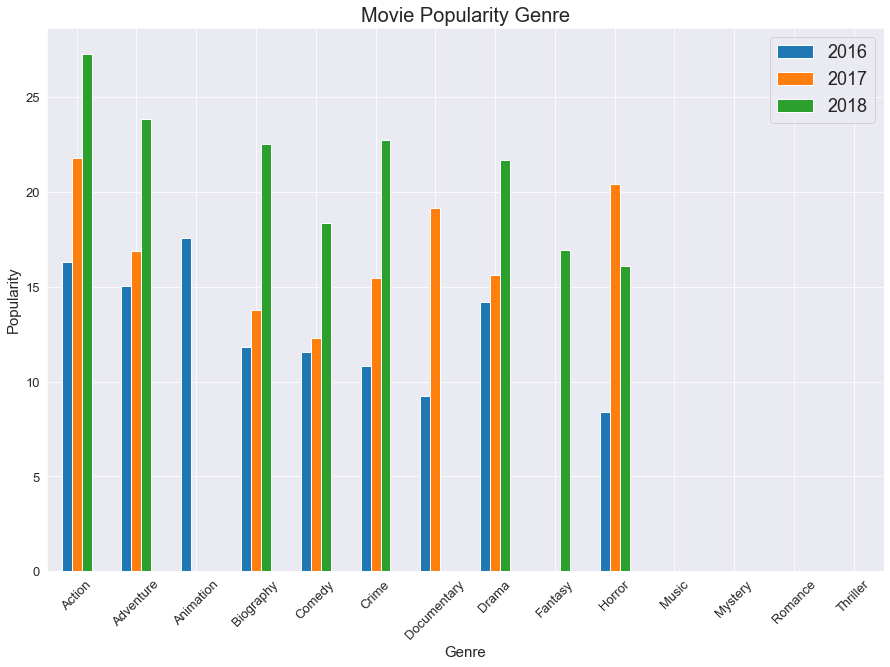

In [461]:
df_merge_pivot_genre_studio.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Movie Popularity Genre", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Popularity", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [464]:
# Create pivot table of genre vs year of attributes to be mapped
df_merge_pivot_genre_wwprofit = pd.pivot_table(df_merge, values='worldwide_profit', index='prim_genre', columns='year',
                                             aggfunc='sum')
df_merge_pivot_genre_wwprofit

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
prim_genre,,,,,,,,,
Action,4.145814e+09,6.125821e+09,5.730219e+09,5.195790e+09,1.114663e+10,7.686518e+09,7.615839e+09,1.076894e+10,9.861673e+09
Adventure,3.583042e+09,2.139197e+09,3.843149e+09,4.760628e+09,2.857123e+09,4.231219e+09,5.938693e+09,4.052758e+09,1.913393e+09
Animation,4.744646e+08,NaN,3.356566e+08,NaN,NaN,3.849126e+08,1.118910e+09,NaN,NaN
Biography,3.210828e+08,1.140003e+08,3.756124e+08,9.117903e+08,6.236499e+08,6.383135e+08,1.180974e+09,1.249881e+09,1.424737e+09
Comedy,1.633742e+09,2.470751e+09,2.051806e+09,1.336557e+09,1.022122e+09,1.276695e+09,1.722204e+09,7.172641e+08,1.085460e+09
Crime,1.705618e+08,4.714509e+07,4.876159e+07,8.997496e+08,8.437439e+07,3.426812e+08,9.317834e+07,3.789892e+08,1.753784e+08
Documentary,8.788070e+06,8.603412e+07,2.070044e+07,5.854179e+07,1.731787e+07,1.873556e+08,-1.472120e+06,1.844869e+08,NaN
Drama,1.116354e+09,7.351414e+08,1.172494e+09,8.130236e+08,8.641591e+08,1.640773e+09,1.360088e+09,1.219525e+09,8.748355e+08
Fantasy,NaN,4.967844e+07,3.012862e+06,NaN,NaN,NaN,NaN,NaN,-1.296538e+07


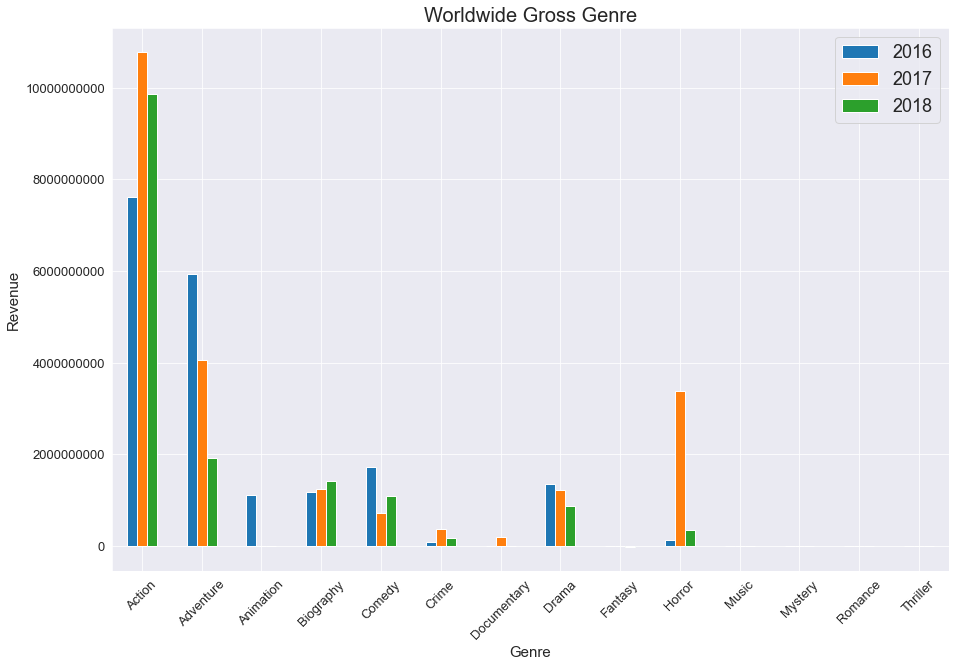

In [466]:
df_merge_pivot_genre_wwprofit.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Worldwide Gross Genre", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Revenue", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [113]:
# let calculate some statistics and group by year 
df_merge_prim_genre_avg = df_merge.groupby('prim_genre').mean()
df_merge_prim_genre_sum = df_merge.groupby('prim_genre').sum()

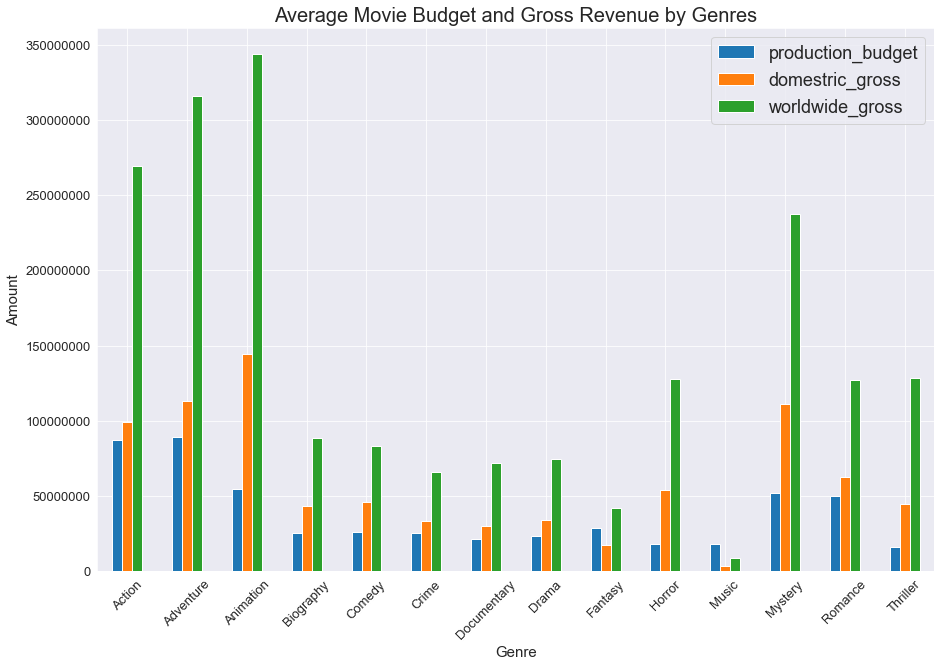

In [206]:
df_merge_prim_genre_avg.iloc[:, 0:3].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Movie Budget and Gross Revenue by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Average_movie_revenue_by_genres.png')

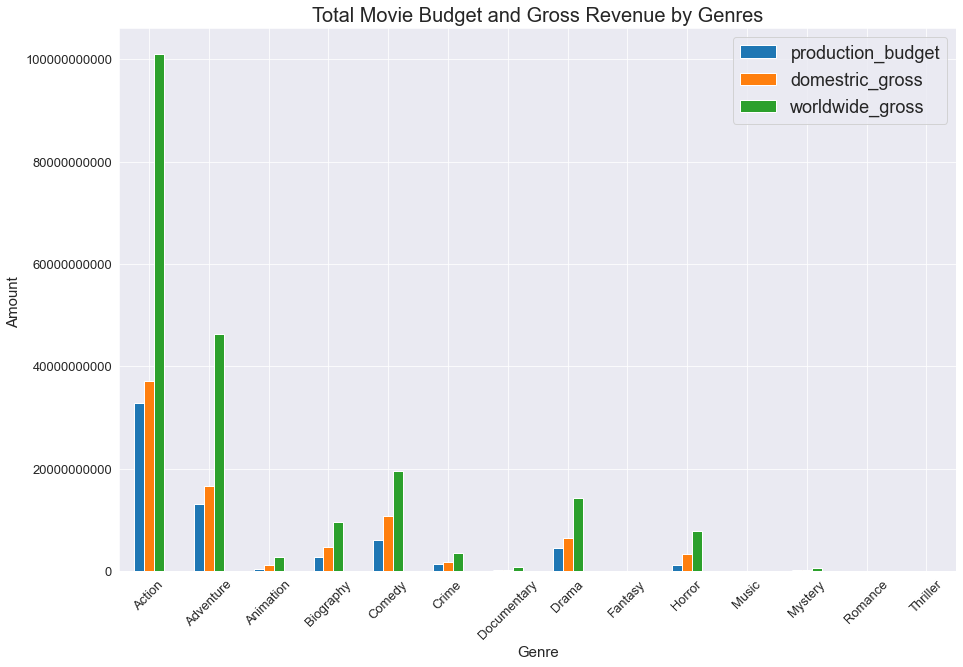

In [207]:
df_merge_prim_genre_sum.iloc[:, 0:3].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Total Movie Budget and Gross Revenue by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount ", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Total_movie_budget_vs_revenue_by_genres.png')

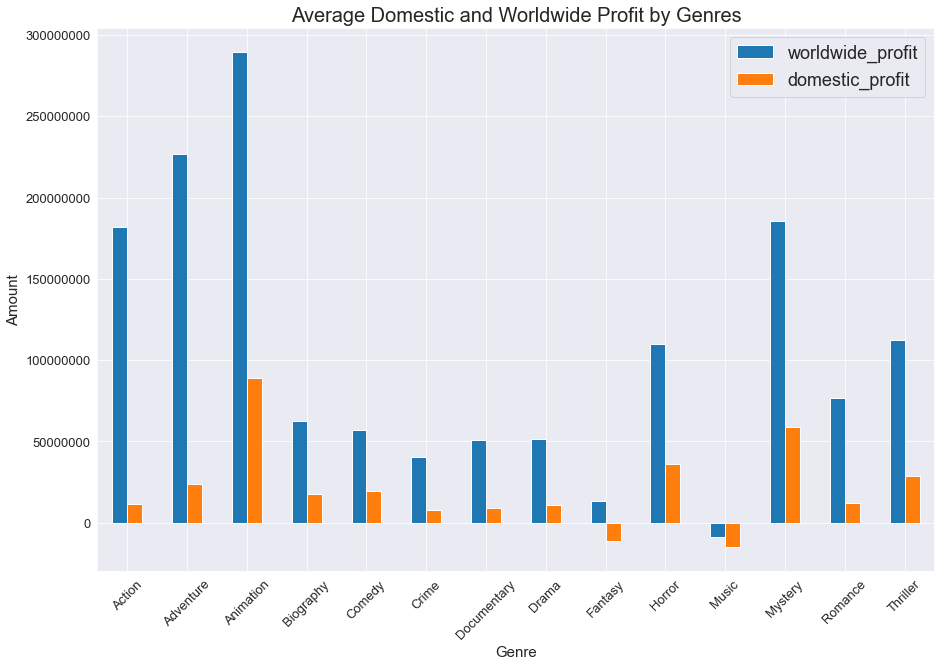

In [208]:
df_merge_prim_genre.iloc[:, 5:7].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Domestic and Worldwide Profit by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Average_profit_by_genres.png')

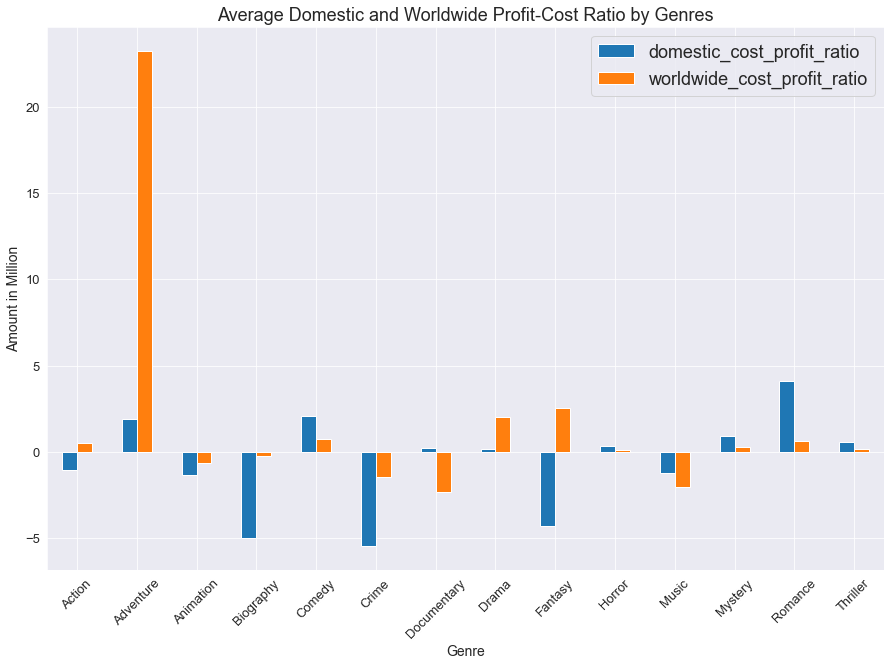

In [112]:
df_merge_prim_genre.iloc[:, 7:9].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Domestic and Worldwide Profit-Cost Ratio by Genres", fontsize = 18)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount in Million", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [127]:
df_merge_prim_genre.head()

,production_budget,domestric_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,domestic_gross_n,worldwide_gross_n,runtime_minutes,averagerating,numvotes,popularity,vote_average,vote_count
prim_genre,,,,,,,,,,,,,,,,,
Action,8.756133e+07,9.905137e+07,2.696340e+08,2013.960000,1.705826e+08,1.820727e+08,1.149003e+07,-1.031952,0.541747,0.751017,0.932365,114.192000,6.474933,204066.885333,18.004987,6.337333,3778.874667
Adventure,8.917959e+07,1.132622e+08,3.158408e+08,2014.068027,2.025786e+08,2.266612e+08,2.408264e+07,1.933706,23.201092,0.953173,1.187479,104.204082,6.470748,151010.646259,15.947265,6.426531,3164.619048
Animation,5.487500e+07,1.441239e+08,3.441179e+08,2013.875000,1.999940e+08,2.892429e+08,8.924895e+07,-1.362304,-0.642680,1.392195,1.343600,94.750000,7.162500,149924.750000,15.735625,6.950000,3799.875000
Biography,2.574560e+07,4.367455e+07,8.849827e+07,2014.807339,4.482372e+07,6.275267e+07,1.792895e+07,-5.008121,-0.236794,-0.036743,-0.067707,119.174312,7.096330,125877.944954,12.787569,7.012844,1955.541284
Comedy,2.636449e+07,4.577686e+07,8.327305e+07,2013.230769,3.749619e+07,5.690856e+07,1.941237e+07,2.095630,0.775141,-0.006837,-0.096556,103.820513,6.229487,93194.226496,10.972739,6.202137,1409.029915


In [136]:
df_merge_prim_genre.columns

Index(['production_budget', 'domestric_gross', 'worldwide_gross', 'year',
       'foreign_gross', 'worldwide_profit', 'domestic_profit',
       'domestic_cost_profit_ratio', 'worldwide_cost_profit_ratio',
       'domestic_gross_n', 'worldwide_gross_n', 'runtime_minutes',
       'averagerating', 'numvotes', 'popularity', 'vote_average',
       'vote_count'],
      dtype='object')

In [140]:
df.head()

,prim_genre,production_budget,domestric_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,domestic_gross_n,worldwide_gross_n,runtime_minutes,averagerating,numvotes,popularity,vote_average,vote_count
0,Action,8.756133e+07,9.905137e+07,2.696340e+08,2013.960000,1.705826e+08,1.820727e+08,1.149003e+07,-1.031952,0.541747,0.751017,0.932365,114.192000,6.474933,204066.885333,18.004987,6.337333,3778.874667
1,Adventure,8.917959e+07,1.132622e+08,3.158408e+08,2014.068027,2.025786e+08,2.266612e+08,2.408264e+07,1.933706,23.201092,0.953173,1.187479,104.204082,6.470748,151010.646259,15.947265,6.426531,3164.619048
2,Animation,5.487500e+07,1.441239e+08,3.441179e+08,2013.875000,1.999940e+08,2.892429e+08,8.924895e+07,-1.362304,-0.642680,1.392195,1.343600,94.750000,7.162500,149924.750000,15.735625,6.950000,3799.875000
3,Biography,2.574560e+07,4.367455e+07,8.849827e+07,2014.807339,4.482372e+07,6.275267e+07,1.792895e+07,-5.008121,-0.236794,-0.036743,-0.067707,119.174312,7.096330,125877.944954,12.787569,7.012844,1955.541284
4,Comedy,2.636449e+07,4.577686e+07,8.327305e+07,2013.230769,3.749619e+07,5.690856e+07,1.941237e+07,2.095630,0.775141,-0.006837,-0.096556,103.820513,6.229487,93194.226496,10.972739,6.202137,1409.029915


In [156]:
# Helper function for categrical and numerical bar plot

def cat_plot(df, kind, x, y, color, orient, title, alpha):
    '''
    Plot combination numerical and categorical variables as bar chart.
    '''
    if orient == 'v':
        fig = sns.catplot(data=df, kind=kind, x=x, y=y, color=color, alpha=alpha, orient=orient, aspect=2)
        fig.set_xlabels(fontsize=14)
        fig.set_ylabels(fontsize=14)
        fig.set_xticklabels(fontsize=10)
        fig.set_yticklabels(fontsize=10)
        fig.set(title=title)
        fig.set_titles(fontsize=18);
        
    elif orient == 'h':
        fig = sns.catplot(data=df, kind=kind, x=x, y=y, color=color, alpha=alpha, orient=orient, aspect=1, height=10)
        fig.set_xlabels(fontsize=14)
        fig.set_ylabels(fontsize=14)
        fig.set_xticklabels(fontsize=10)
        fig.set_yticklabels(fontsize=10)
        fig.set(title=title)
        fig.set_titles(fontsize=18);
        

def plot_basic(df, x, y, hue, type):
    
    if type == 'hist':
        fig, ax = plt.subplots()
        ax = sns.displot(data=df, x=x, kind = 'hist')
    elif type == 'scatter':
        fig, ax = plt.subplots()
        ax = sns.scatterplot(data=df, x=x, y=y, hue=hue)      
    

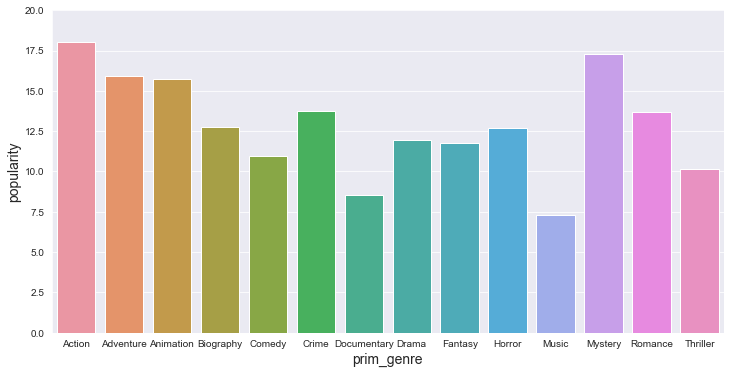

In [158]:
df = df_merge_prim_genre.reset_index()
cat_plot(df, kind='bar', x=df.prim_genre, y=df.popularity,color=None, orient='v', title=None, alpha=None)

In [209]:
df_merge.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count,prim_genre,second_genre,tertiary_genre
0,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,...,6.6,447624,"Action,Adventure,Fantasy",BV,30.579,6.4,8571,Action,Adventure,Fantasy
1,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,...,7.3,665594,"Action,Adventure,Sci-Fi",BV,44.383,7.3,13457,Action,Adventure,Sci-Fi
2,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,1.369319e+09,1.748134e+09,378815482.0,0.791942,0.171612,...,8.5,670926,"Action,Adventure,Sci-Fi",BV,80.773,8.3,13948,Action,Adventure,Sci-Fi
3,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy
4,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy


C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='studio'>

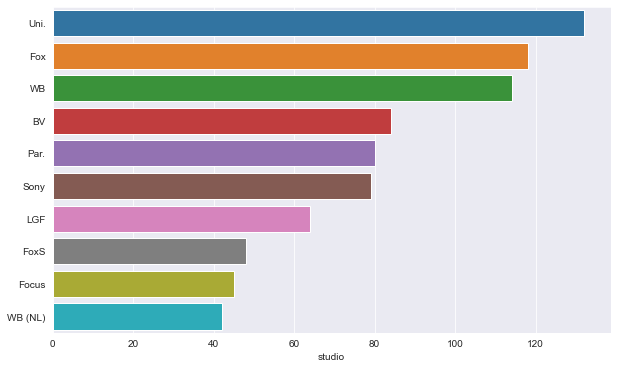

In [211]:
x = df_merge['studio'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x, x.index)

In [279]:
w = df_merge['production_budget'].sort_values()
x = df_merge['domestic_gross'].sort_values()
y = df_merge['worldwide_gross'].sort_values()
z = df_merge['foreign_gross'].sort_values()

# plt.figure(figsize=(15,8))
fig.set_tight_layout(True)

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# axes[0][0].hist(w, bins=40)
# plt.xlabel('production budget')
# axes[0][1].hist(x, bins=40)
# axes[1][0].hist(y, bins=40)
# axes[1][1].hist(z, bins=40);
# sns.displot(w, kind='hist')
# sns.displot(x, kind='hist')
# sns.displot(y, kind='hist')
# sns.displot(z, kind='hist');


In [281]:
df_merge.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count,prim_genre,second_genre,tertiary_genre
0,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,...,6.6,447624,"Action,Adventure,Fantasy",BV,30.579,6.4,8571,Action,Adventure,Fantasy
1,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,...,7.3,665594,"Action,Adventure,Sci-Fi",BV,44.383,7.3,13457,Action,Adventure,Sci-Fi
2,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,1.369319e+09,1.748134e+09,378815482.0,0.791942,0.171612,...,8.5,670926,"Action,Adventure,Sci-Fi",BV,80.773,8.3,13948,Action,Adventure,Sci-Fi
3,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy
4,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510,Action,Adventure,Fantasy


In [120]:
df_merge_prim_genre_yearly_avg = df_merge.groupby(['prim_genre', 'year']).mean()
df_merge_prim_genre_yearly_avg.head()

production_budget  domestric_gross  worldwide_gross  \
prim_genre year                                                        
Action     2010       7.268636e+07     7.141758e+07     1.669094e+08   
           2011       7.665000e+07     7.360678e+07     2.158732e+08   
           2012       8.125897e+07     8.837403e+07     2.281877e+08   
           2013       9.414474e+07     9.048759e+07     2.308761e+08   
           2014       9.104651e+07     1.291789e+08     3.502705e+08   

                 foreign_gross  worldwide_profit  domestic_profit  \
prim_genre year                                                     
Action     2010   9.549183e+07      9.422305e+07    -1.268782e+06   
           2011   1.422664e+08      1.392232e+08    -3.043215e+06   
           2012   1.398136e+08      1.469287e+08     7.115053e+06   
           2013   1.403885e+08      1.367313e+08    -3.657152e+06   
           2014   2.210916e+08      2.592240e+08     3.813241e+07   

                 domestic_cost_profit_ratio  worldwide_cost_profit_ratio  \
prim_genre year                                                            
Action     2010                   -1.387529                     0.572905   
           2011                    0.081896                     0.487903   
           2012                   -0.923322                     2.624739   
           2013                    0.945189                    -0.083408   
           2014                    0.364161                     1.196636   

                 domestic_gross_n  worldwide_gross_n  runtime_minutes  \
prim_genre year                                                         
Action     2010          0.357914           0.365211       106.568182   
           2011          0.389057           0.635546       108.386364   
           2012          0.599127           0.703535       112.076923   
           2013          0.629194           0.718378       116.315789   
           2014          1.179596           1.377569       115.046512   

                 averagerating       numvotes  popularity  vote_average  \
prim_genre year                                                           
Action     2010       6.334091  204335.409091   13.401455      6.170455   
           2011       6.309091  191814.681818   13.574886      6.138636   
           2012       6.392308  231470.230769   13.749000      6.148718   
           2013       6.528947  240095.710526   16.148211      6.313158   
           2014       6.627907  271151.558140   21.882535      6.588372   

                  vote_count  
prim_genre year               
Action     2010  2697.068182  
           2011  2807.931818  
           2012  3322.025641  
           2013  3972.105263  
           2014  5194.883721

In [167]:
df_merge_pop_genre_year = df_merge_prim_genre_yearly_avg.reset_index('year')
df_merge_pop_genre_year.head()

,year,production_budget,domestric_gross,worldwide_gross,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,domestic_gross_n,worldwide_gross_n,runtime_minutes,averagerating,numvotes,popularity,vote_average,vote_count
prim_genre,,,,,,,,,,,,,,,,,
Action,2010,7.268636e+07,7.141758e+07,1.669094e+08,9.549183e+07,9.422305e+07,-1.268782e+06,-1.387529,0.572905,0.357914,0.365211,106.568182,6.334091,204335.409091,13.401455,6.170455,2697.068182
Action,2011,7.665000e+07,7.360678e+07,2.158732e+08,1.422664e+08,1.392232e+08,-3.043215e+06,0.081896,0.487903,0.389057,0.635546,108.386364,6.309091,191814.681818,13.574886,6.138636,2807.931818
Action,2012,8.125897e+07,8.837403e+07,2.281877e+08,1.398136e+08,1.469287e+08,7.115053e+06,-0.923322,2.624739,0.599127,0.703535,112.076923,6.392308,231470.230769,13.749000,6.148718,3322.025641
Action,2013,9.414474e+07,9.048759e+07,2.308761e+08,1.403885e+08,1.367313e+08,-3.657152e+06,0.945189,-0.083408,0.629194,0.718378,116.315789,6.528947,240095.710526,16.148211,6.313158,3972.105263
Action,2014,9.104651e+07,1.291789e+08,3.502705e+08,2.210916e+08,2.592240e+08,3.813241e+07,0.364161,1.196636,1.179596,1.377569,115.046512,6.627907,271151.558140,21.882535,6.588372,5194.883721


In [ ]:
df_merge_pop_genre = df_merge_pop_genre_year.loc[df_merge_pop_genre_year['popularity']]

### Going back to imdb dataset
Lets evaluate IMDB dataset in terms of primary and secondary genre

In [498]:
df_imdb_merge_copy = df_imdb_merge.copy(deep=True)
df_imdb_merge_copy.head()

,runtime_minutes,averagerating,numvotes,title,year,genre,title_edit
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama",sunghursh
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama",ashad ka ek din
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama,the other side of the wind
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama",sabse bada sukh
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",la telenovela errante


In [499]:
# Add primary genre
df_imdb_merge_copy['first_genre'] = df_imdb_merge_copy['genre'].str.split(',', expand=True)[0]
df_imdb_merge_copy['second_genre'] = df_imdb_merge_copy['genre'].str.split(',', expand=True)[1]

In [505]:
df_imdb_merge_copy.head(3)

,runtime_minutes,averagerating,numvotes,title,year,genre,title_edit,first_genre,second_genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama",sunghursh,Action,Crime
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama",ashad ka ek din,Biography,Drama
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama,the other side of the wind,Drama,None


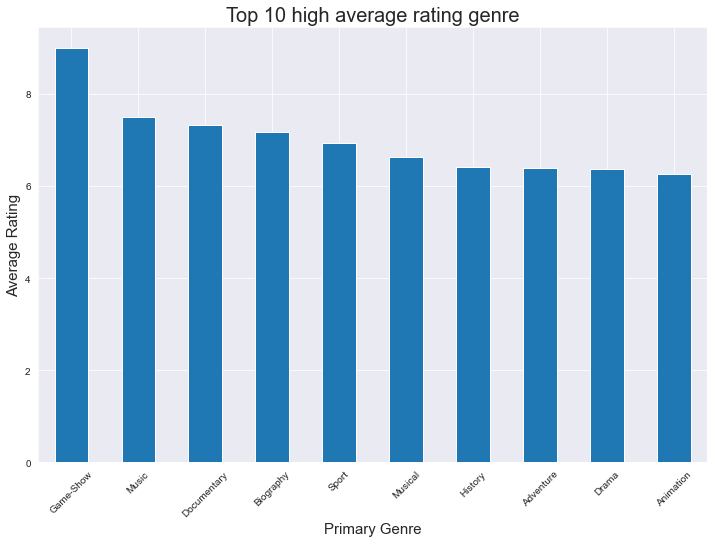

In [508]:
df_imdb_merge_copy.groupby(['first_genre'])['averagerating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 high average rating genre', fontsize=20);

In [502]:
df_imdb_merge_copy.head()

,runtime_minutes,averagerating,numvotes,title,year,genre,title_edit,first_genre,second_genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama",sunghursh,Action,Crime
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama",ashad ka ek din,Biography,Drama
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama,the other side of the wind,Drama,None
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama",sabse bada sukh,Comedy,Drama
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",la telenovela errante,Comedy,Drama


In [487]:
df_imdb_merge_genre_avgrating = pd.pivot_table(df_imdb_merge_copy, values='averagerating', index='first_genre', columns='year', aggfunc='mean')
df_imdb_merge_genre_avgrating.fillna(0).head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
first_genre,,,,,,,,,,
Action,5.692330,5.731503,5.880897,5.707252,5.868435,5.728377,5.816434,5.885831,5.853352,6.216176
Adult,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
Adventure,6.332857,6.334615,6.405000,6.422781,6.491223,6.345981,6.349675,6.282292,6.418987,6.710769
Animation,6.602326,6.206195,6.196667,6.333333,6.335238,6.167857,6.314414,6.344643,5.933028,5.961290
Biography,7.128205,7.242442,7.228451,7.130998,7.277939,7.185682,7.185028,7.042466,6.962009,7.355263


In [489]:
df_imdb_merge_genre_avgrating.drop(['Adult', 'Biography', 'Documentary', 'Game-Show', 'History',
                                        'Musical', 'News', 'Reality-TV', 'Sport'], axis=0, inplace=True)

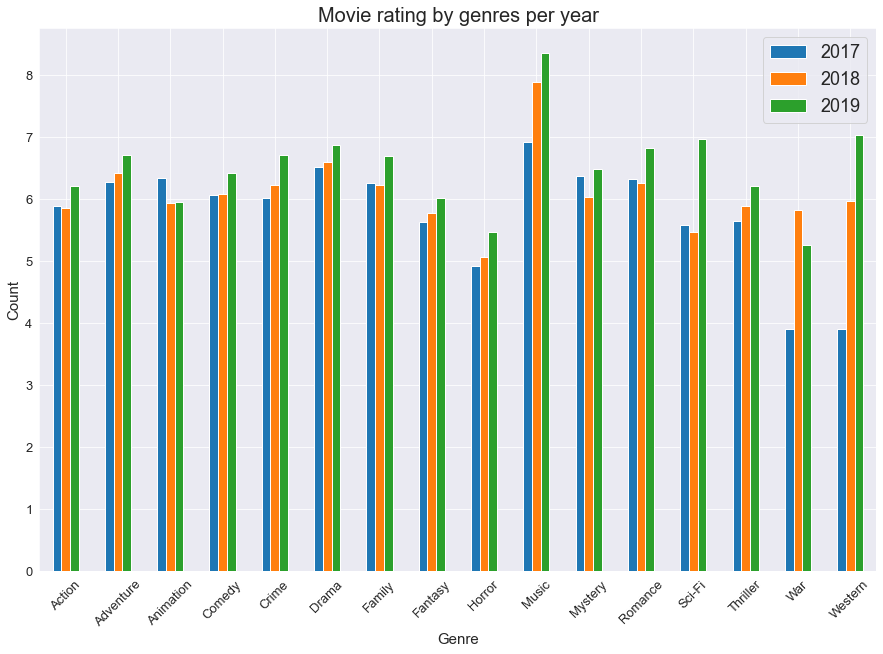

In [495]:
df_imdb_merge_genre_avgrating.iloc[0:, 7:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Movie rating by genres per year", fontsize = 20)
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Movie_rating_by_genres_imdb_dataset.png')

In [491]:
df_imdb_merge_genre_numvotes = pd.pivot_table(df_imdb_merge_copy, values='numvotes', index='first_genre', columns='year', aggfunc='mean')
df_imdb_merge_genre_numvotes.fillna(0).head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
first_genre,,,,,,,,,,
Action,16314.832127,16557.595376,17831.804631,17146.595537,18601.676585,12750.468401,12541.120047,11039.557377,10373.015692,8265.294118
Adult,0.000000,0.000000,0.000000,0.000000,0.000000,128.000000,0.000000,0.000000,0.000000,0.000000
Adventure,19928.814286,11289.853846,15671.319231,11465.378698,12054.777429,7979.765273,9288.837662,5168.614583,4932.413502,2052.415385
Animation,6197.453488,739.106195,4189.044444,1465.344086,576.076190,1810.955357,3817.828829,706.598214,456.036697,106.000000
Biography,6013.253205,5121.447674,3690.597183,7623.346072,3809.075949,4379.827740,5379.011299,5078.452055,7012.266376,2719.657895


In [492]:
df_imdb_merge_genre_numvotes.drop(['Adult', 'Biography', 'Documentary', 'Game-Show', 'History',
                                        'Musical', 'News', 'Reality-TV', 'Sport'], axis=0, inplace=True)

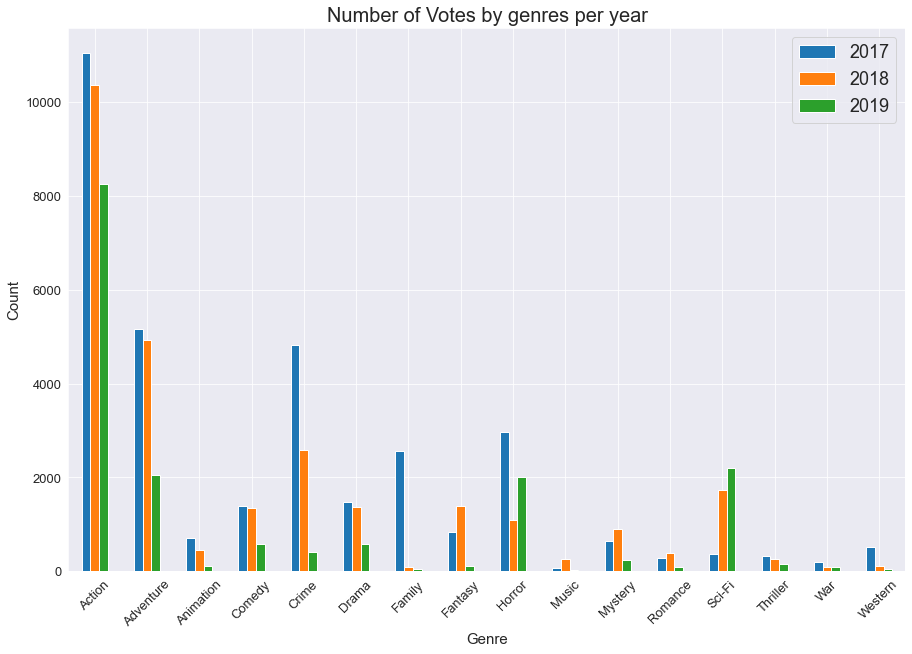

In [496]:
df_imdb_merge_genre_numvotes.iloc[0:, 7:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Number of Votes by genres per year", fontsize = 20)
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Num_vote_by_genres_imdb_dataset.png')

In [503]:
df_imdb_merge_genre_movie_count = pd.pivot_table(df_imdb_merge_copy, values='numvotes', index='first_genre', columns='year', aggfunc='count')
df_imdb_merge_genre_movie_count.fillna(0).head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
first_genre,,,,,,,,,,
Action,691.0,692.0,691.0,717.0,773.0,807.0,858.0,854.0,701.0,204.0
Adult,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Adventure,210.0,260.0,260.0,338.0,319.0,311.0,308.0,288.0,237.0,65.0
Animation,86.0,113.0,90.0,93.0,105.0,112.0,111.0,112.0,109.0,31.0
Biography,312.0,344.0,355.0,471.0,553.0,447.0,354.0,292.0,229.0,76.0


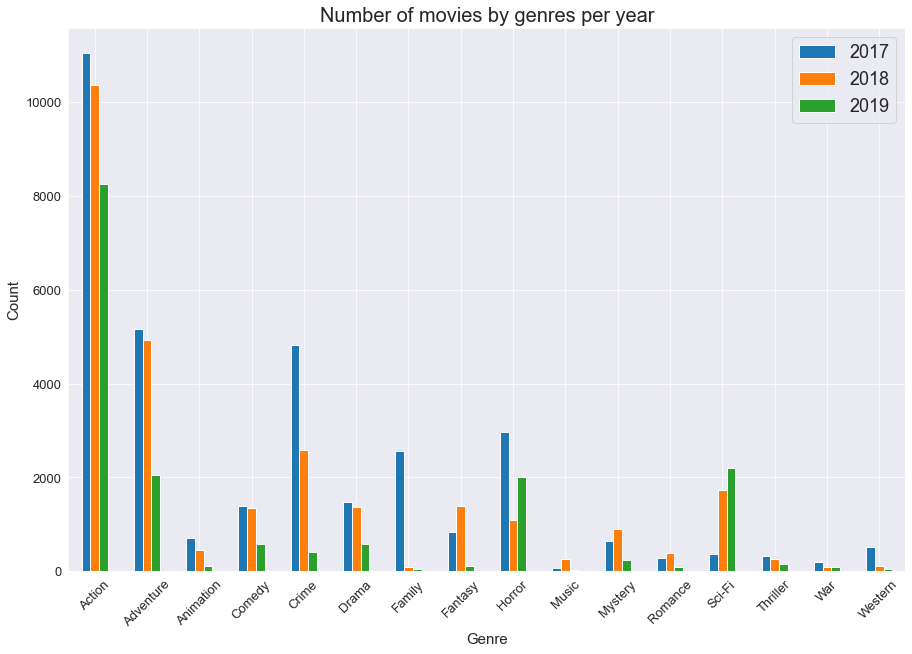

In [504]:
df_imdb_merge_genre_numvotes.iloc[0:, 7:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Number of movies by genres per year", fontsize = 20)
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
# plt.savefig('Num_vote_by_genres_imdb_dataset.png')